In [2795]:
#!jt -t oceans16 -f roboto -fs 12 -cellw 100%

In [2796]:
import math
import matplotlib.pyplot as plt
import numpy as np
import openpyxl
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import xlsxwriter
from copy import copy
from sklearn import tree, metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.impute import KNNImputer
from sklearn.metrics import auc, roc_curve 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from statsmodels.discrete.discrete_model import Logit 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from varclushi import VarClusHi

In [2797]:
#Important parameters
target_name='default_cross12'
time_name='period'
event_rate_name='BR'
event_name='Bad'
prob_event='PD'
nonevent_name='Good'
share_name='Share'
variable_name='Variable'
grp_name='GRP'
all_name='All'
logit_name='Logit'
condition_name='Condition'
time_report_name='Time'
intercept_name='Intercept'
score_name='Score'
beta_name='Beta'
fbeta_name='FBeta'
id_row='aid'
gini_train='Gini train'
gini_test='Gini test'
delta_gini='R. Gini'
estimation='Estimation'
pvalue='P-value'
max_pvalue='Max p-value'
max_vif='Max VIF'
max_con_index='Max Con Index'
max_pearson='Max Pearson'
nnegative_betas='N negative betas'
wald_test='Wald test'
degree_free='Degrees of freedom'
std_err='Standard error'
bad_share='Bad share'
good_share='Good share'
INV='Infomration Value'
PSI='Population Stability Index'
PSI_tar='Population Stability Index for bads'
share_name_test='Share test'
bad_share_test='Bad share test'
type_name='Type'
percent_missing='Missing percent'
count_unique='Number of distinct'
event_value='outstanding_bad'
all_value='outstanding'
event_rate_name_value='BRBal'
nonevent_name_value='Balance good'
share_name_value='Balance share'
mode_name='Mode'
mode_pname='P. mode'
type_name='Type'


#Bining for numerical variables
ncategories_int=4 #zmiana
minimum_share_int=0.03
symbol_missing='Missing'

#Bining for character variables
symbol_other='<OTHERS>'
#minimum share of unique value
minimum_share_unique=0.15
#minimum_share_unique=0.03 #zmiana
#maximal number of bins
ncategories_nom=3 #zmiana

#option for response model
# category_order=True
#option for risk model
category_order=False
description_results = ""
#description_results += "ncategories_nom=4; "

In [2798]:
# ef = pd.ExcelFile('abt_app_PD_INS.xlsx')
# ef = pd.ExcelFile('abt_app.xls')
# df = ef.parse('Sheet1')

In [2799]:
df = pd.read_sas('data/abt_app.sas7bdat', encoding='LATIN2')

In [2800]:
print(type(df['app_char_job_code'][0]))
print(df['app_char_job_code'][0])

<class 'str'>
Retired


In [2801]:
df=df[('197501'<=df['period']) & (df['period']<='198712') & (df['product']=='css') & (df['decision']=='A')]

In [2802]:
#description_results += "4 new columns; "
df["app_char_job_code_home_status"] = df["app_char_job_code"] + df["app_char_home_status"]
df["app_char_marital_status_gender"] = df["app_char_marital_status"] + df["app_char_gender"]
df["app_char_city_gender"] = df["app_char_city"] + df["app_char_gender"]
df["app_char_marital_status_job_code"] = df["app_char_marital_status"] + df["app_char_job_code"]

In [2803]:
#description_results += "df.drop 4 variables; "
df=df.drop(['app_char_job_code', 'app_char_marital_status', 'app_char_home_status', 'app_char_gender', 'app_char_branch'], axis=1)

In [2804]:
df[intercept_name]=1
df[event_value]=df['app_loan_amount']*df[target_name]
df[all_value]=df['app_loan_amount']
df.head()

,cid,aid,product,period,act_age,act_cc,act_loaninc,app_income,app_loan_amount,app_n_installments,...,default_cross12,cross_app_loan_amount,cross_app_n_installments,app_char_job_code_home_status,app_char_marital_status_gender,app_char_city_gender,app_char_marital_status_job_code,Intercept,outstanding_bad,outstanding
6597,0000000625,css1975010100063,css,197501,55.0,0.629712,1.583782,3157.0,5000.0,24.0,...,0.0,5000.0,24.0,PermanentOwner,MariedFemale,SmallFemale,MariedPermanent,1,0.0,5000.0
6598,0000001330,css1975010100098,css,197501,45.0,0.326905,1.530456,3267.0,5000.0,24.0,...,1.0,5000.0,24.0,PermanentOwner,MariedFemale,BigFemale,MariedPermanent,1,5000.0,5000.0
6599,0000002179,css1975010100120,css,197501,42.0,0.538908,2.903600,1722.0,5000.0,24.0,...,NaN,NaN,NaN,PermanentRental,MariedMale,BigMale,MariedPermanent,1,NaN,5000.0
6600,0000002366,css1975010100123,css,197501,70.0,0.559242,3.949447,1266.0,5000.0,24.0,...,0.0,5000.0,24.0,RetiredOwner,MariedFemale,MediumFemale,MariedRetired,1,0.0,5000.0
6601,0000000079,css1975010200009,css,197501,68.0,0.647492,3.344482,1495.0,5000.0,24.0,...,1.0,5000.0,24.0,RetiredOwner,WidowedMale,BigMale,WidowedRetired,1,5000.0,5000.0


In [2805]:
df.shape 

(25587, 221)

In [2806]:
#Do we have mising values in target variable?
one=df[target_name]
one[one.isnull()==True].head()

6599   NaN
6602   NaN
6604   NaN
6605   NaN
6607   NaN
Name: default_cross12, dtype: float64

In [2807]:
#Dropping mising values in target variable
df_notempty=df.dropna(subset=[target_name])
one2=df_notempty[target_name]
one2[one2.isnull()==True].head()

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/displayhook.py:275: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


Series([], Name: default_cross12, dtype: float64)

In [2808]:
#List of variables
#description_results += " - vars  in ['app','act','agr','ags']- "
vars=[var for var in list(df) if var[0:3].lower() in ['app','act']]
#vars=[var for var in list(df) if var[0:3].lower() in ['app','act','agr','ags']] #zmiana
vars_target_id=vars+[target_name]+[time_name]+[intercept_name]+[event_value]+[all_value]+[id_row]
#vars_target_id

#splitting into numeric and character variables
varsc=list(df[vars].select_dtypes(include='object'))
varsn=list(df[vars].select_dtypes(include='number'))

print(varsc, varsn)
#vars_target_id

['app_char_city', 'app_char_cars', 'app_char_job_code_home_status', 'app_char_marital_status_gender', 'app_char_city_gender', 'app_char_marital_status_job_code'] ['act_age', 'act_cc', 'act_loaninc', 'app_income', 'app_loan_amount', 'app_n_installments', 'app_number_of_children', 'app_spendings', 'app_installment', 'act_call_cc', 'act_cins_n_loan', 'act_ccss_n_loan', 'act_call_n_loan', 'act_cins_seniority', 'act_cins_min_seniority', 'act_cins_n_loans_hist', 'act_cins_n_statC', 'act_cins_n_statB', 'act_cins_n_loans_act', 'act_cins_maxdue', 'act_cins_min_pninst', 'act_cins_min_lninst', 'act_cins_utl', 'act_cins_dueutl', 'act_cins_cc', 'act_ccss_seniority', 'act_ccss_min_seniority', 'act_ccss_n_loans_hist', 'act_ccss_n_statC', 'act_ccss_n_statB', 'act_ccss_n_loans_act', 'act_ccss_maxdue', 'act_ccss_min_pninst', 'act_ccss_min_lninst', 'act_ccss_utl', 'act_ccss_dueutl', 'act_ccss_cc', 'act_cus_active', 'act3_n_arrears', 'act3_n_arrears_days', 'act3_n_good_days', 'act6_n_arrears', 'act6_n_arr

In [2809]:
#Splitting for train and test datasets
#from sklearn.model_selection import train_test_split
description_results += " test_size=0.3; "
train, test = train_test_split(df_notempty[vars_target_id], random_state = 1234, test_size=0.3)
print(train.shape, test.shape)
train.head() 
#train[train[target_name].isnull()==True].head()
#test[test[target_name].isnull()==True].head()

(8943, 62) (3833, 62)


,act_age,act_cc,act_loaninc,app_income,app_loan_amount,app_n_installments,app_number_of_children,app_spendings,app_installment,app_char_city,...,app_char_job_code_home_status,app_char_marital_status_gender,app_char_city_gender,app_char_marital_status_job_code,default_cross12,period,Intercept,outstanding_bad,outstanding,aid
12303,50.0,0.571429,4.152824,1204.0,5000.0,24.0,2.0,480.0,208.0,Big,...,RetiredOwner,MariedFemale,BigFemale,MariedRetired,1.0,197711,1,5000.0,5000.0,css1977110500090
32072,54.0,0.968326,11.312217,442.0,5000.0,24.0,0.0,220.0,208.0,Medium,...,RetiredOwner,MariedFemale,MediumFemale,MariedRetired,1.0,198712,1,5000.0,5000.0,css1987121100097
25756,88.0,0.605607,4.672897,1070.0,5000.0,24.0,1.0,440.0,208.0,Big,...,RetiredOwner,MariedFemale,BigFemale,MariedRetired,0.0,198408,1,0.0,5000.0,css1984082500015
19771,63.0,0.518636,1.982554,2522.0,5000.0,24.0,1.0,1100.0,208.0,Big,...,ContractOwner,MariedFemale,BigFemale,MariedContract,1.0,198107,1,5000.0,5000.0,css1981071500007
13862,73.0,0.434596,3.573981,1399.0,5000.0,24.0,0.0,400.0,208.0,Big,...,RetiredRental,MariedFemale,BigFemale,MariedRetired,0.0,197808,1,0.0,5000.0,css1978080600056


In [2810]:
#knn imputer
varsn_tar = varsn + [target_name]
train_varsn_tar = train[varsn_tar].copy()
cols = train_varsn_tar.columns
imputer = KNNImputer(missing_values=np.nan, n_neighbors=7)
imputer.fit(train_varsn_tar)
train_varsn_tar = imputer.transform(train_varsn_tar) 
train_varsn_tar = pd.DataFrame(train_varsn_tar, columns=cols)

In [2811]:
#OptimalBinning
from optbinning import OptimalBinning
labsn = {}
for col in train_varsn_tar[varsn_tar].columns:
    x = train_varsn_tar[col]
    y = train_varsn_tar[target_name]
    optb = OptimalBinning(name=col, dtype="numerical", solver="cp", cat_unknown="woe", min_n_bins=3, max_n_bins=5 ,min_prebin_size=0.05)
    optb.fit(x, y)
    labsn[col] = None
    if len(list(optb.splits)) == 0:
        labsn[col] = [-np.inf, np.inf]
    else:
        list_round = [round(s, 1) for s in list(optb.splits)]
        list_round.insert(0,-np.inf)
        list_round.insert(len(list_round),np.inf)
        labsn[col] = list_round
labsn['app_number_of_children']=[-np.inf, 1, 2, np.inf]
labsn['act_ccss_n_statC']=[-np.inf, 5, 21, np.inf]
labsn['act_ccss_maxdue']=[-np.inf, 0.5, 1.5, np.inf]
labsn['act6_n_arrears']=[-np.inf, 1.5, 2.5, 5.5, np.inf]
labsn['act_ccss_min_lninst']=[-np.inf, 1.5, 6, np.inf]
labsn.pop(target_name)
labsn

{'act_age': [-inf, 60.5, 69.5, 74.5, 81.5, inf],
 'act_cc': [-inf, 0.3, 0.5, 0.7, 0.9, inf],
 'act_loaninc': [-inf, 1.5, 3.6, 4.8, 8.6, inf],
 'app_income': [-inf, 581.0, 1051.5, 1373.5, 3323.0, inf],
 'app_loan_amount': [-inf, inf],
 'app_n_installments': [-inf, inf],
 'app_number_of_children': [-inf, 1, 2, inf],
 'app_spendings': [-inf, 250.0, 430.0, 470.0, 870.0, inf],
 'app_installment': [-inf, inf],
 'act_call_cc': [-inf, 0.7, 1.4, 1.4, 1.6, inf],
 'act_cins_n_loan': [-inf, inf],
 'act_ccss_n_loan': [-inf, 2.5, 3.5, 4.5, 5.5, inf],
 'act_call_n_loan': [-inf, 3.5, 4.5, 5.5, inf],
 'act_cins_seniority': [-inf, 58.5, 145.5, 163.5, 181.5, inf],
 'act_cins_min_seniority': [-inf, 16.5, 43.5, 55.5, 107.5, inf],
 'act_cins_n_loans_hist': [-inf, 1.5, 3.5, 4.5, 7.5, inf],
 'act_cins_n_statC': [-inf, 1.5, 3.5, 4.5, 5.5, inf],
 'act_cins_n_statB': [-inf, 0.5, 1.5, inf],
 'act_cins_n_loans_act': [-inf, 1.1, 1.2, inf],
 'act_cins_maxdue': [-inf, 0.1, 0.4, 0.8, 1.1, inf],
 'act_cins_min_pninst':

In [2812]:
train.groupby(feature).mean()

,act_age,act_cc,act_loaninc,app_income,app_loan_amount,app_n_installments,app_number_of_children,app_spendings,app_installment,act_call_cc,...,act9_n_arrears,act9_n_arrears_days,act9_n_good_days,act12_n_arrears,act12_n_arrears_days,act12_n_good_days,default_cross12,Intercept,outstanding_bad,outstanding
act_cins_n_loans_hist,,,,,,,,,,,,,,,,,,,,,
1.0,60.648119,0.547432,3.955690,1763.884473,5000.0,24.0,1.176471,641.791203,208.0,1.068996,...,7.163752,0.713302,3.668256,9.228405,0.876524,4.967144,0.807631,1.0,4038.155803,5000.0
2.0,64.014108,0.589143,4.451431,1624.879233,5000.0,24.0,0.878668,640.891648,208.0,1.189504,...,6.654628,0.625282,3.582393,8.580135,0.770316,4.858916,0.779345,1.0,3896.726862,5000.0
3.0,64.681546,0.608307,4.875105,1497.177215,5000.0,24.0,0.750833,570.446369,208.0,1.266977,...,7.029980,0.688208,3.510326,9.053964,0.849434,4.718188,0.799467,1.0,3997.335110,5000.0
4.0,67.179283,0.587982,4.594763,1579.422311,5000.0,24.0,0.646215,596.685259,208.0,1.242333,...,6.688446,0.589641,3.285259,8.658964,0.739442,4.405578,0.716335,1.0,3581.673307,5000.0
5.0,67.228540,0.571174,4.387797,1612.983278,5000.0,24.0,0.580825,607.580825,208.0,1.207312,...,6.670011,0.598662,3.286511,8.583055,0.752508,4.428094,0.739130,1.0,3695.652174,5000.0
6.0,69.273002,0.567176,4.481476,1567.355958,5000.0,24.0,0.384615,578.853695,208.0,1.203897,...,6.941176,0.704374,3.346908,9.003017,0.895928,4.452489,0.748115,1.0,3740.573152,5000.0
7.0,65.831978,0.574436,4.352221,1870.574526,5000.0,24.0,0.577236,711.761518,208.0,1.189347,...,6.826558,0.609756,3.243902,8.826558,0.747967,4.382114,0.753388,1.0,3766.937669,5000.0
8.0,64.447619,0.651398,5.866245,1449.647619,5000.0,24.0,0.480952,560.666667,208.0,1.325620,...,7.333333,0.557143,3.176190,9.547619,0.709524,4.242857,0.809524,1.0,4047.619048,5000.0
9.0,64.787037,0.574055,4.520263,1855.481481,5000.0,24.0,0.574074,679.259259,208.0,1.151434,...,6.675926,0.509259,3.527778,8.638889,0.629630,4.731481,0.759259,1.0,3796.296296,5000.0


In [2813]:
varsc

['app_char_city',
 'app_char_cars',
 'app_char_job_code_home_status',
 'app_char_marital_status_gender',
 'app_char_city_gender',
 'app_char_marital_status_job_code']

In [2814]:
# #Bining for numerical variables

# # remove_list = []
# labsn = {} # binns lists

# for feature in varsn:
#     #feature='app_income'
#     miss_share=train[feature].isnull().sum()/train[feature].shape[0]
#     miss_share=1-miss_share
#     if miss_share<=0.00001:
#         miss_share=1
#     minimum_share=minimum_share_int/miss_share
#     if minimum_share>0.5:
#         minimum_share=0.5
#     if minimum_share<minimum_share_int:
#         minimum_share=minimum_share_int
#     df_two_col=train[[target_name,feature]].dropna(subset=[feature]).copy()
#     # binns list with [min,max]
#     bins = [-np.inf, np.inf]
#     # get Tree classifier - check if we need another parameters !!
#     clf = tree.DecisionTreeClassifier(
#         max_leaf_nodes=ncategories_int,
#         min_weight_fraction_leaf=minimum_share,
#         random_state=1234) 
#     # fit tree
#     clf.fit(df_two_col[feature].values.reshape(-1, 1), df_two_col[target_name])
#     # get tresholds and remove empty
#     thresh = [round(s, 3) for s in clf.tree_.threshold if s != -2]  
#     # add tresholds to binns
#     bins = bins + thresh 
#     bins=sorted(bins)
#     if train[feature].isnull().sum()/train[feature].shape[0] > minimum_share_int:
#         bins=bins + [symbol_missing]
#     labsn[feature]=bins
    

# #labsn['app_number_of_children']=[-np.inf, 1, 1, 2, np.inf] #todo
# labsn #zmiana odkomentowane

In [2815]:
# train.groupby(feature).mean()

In [2816]:
varsc

['app_char_city',
 'app_char_cars',
 'app_char_job_code_home_status',
 'app_char_marital_status_gender',
 'app_char_city_gender',
 'app_char_marital_status_job_code']

In [2817]:
#Bining for character variables

#from sklearn.cluster import AgglomerativeClustering
# remove_list = []
labsc = {} # binns lists

for feature in varsc:
    print("--------------------------", feature, "--------------------------") 
    df_two_col1=pd.DataFrame(train.groupby(feature)[target_name].count()/train.shape[0])
    print("df_two_col1", df_two_col1.head())
    df_two_col2=pd.DataFrame(train.groupby(feature)[target_name].mean())
    print("-----------------------------------------------------------------------------------------------df_two_col2\n", df_two_col2.head())
    df_two_col=df_two_col2
    df_two_col['share']=df_two_col1[target_name]
    df_two_col = df_two_col.loc[df_two_col['share'] > minimum_share_unique]
    ncategoriesv = min(ncategories_nom, df_two_col.shape[0])
    print("-----------------------------------------------------------------------------------------------ncategoriesv\n", ncategoriesv)
    if ncategoriesv >= 2:
        #zmiana affinity='euclidean'
        cluster = AgglomerativeClustering(n_clusters=ncategoriesv, affinity='euclidean', linkage='ward')
        cluster.fit_predict(df_two_col[[target_name]])
        #zmiana - A value is trying to be set on a copy of a slice from a DataFrame.
        #df_two_col['cluster']= cluster.labels_.reshape(-1,1)
        df_two_col.loc[:, 'cluster'] = cluster.labels_.reshape(-1,1)

        print("-----------------------------------------------------------------------------------------------cluster\n", cluster, df_two_col.head(3))
    else:
        #zmiana
        df_two_col['cluster'] = 0
        #df_two_col.loc[:, 'cluster'] = 0
       #df_two_col.loc.__setitem__((slice(None), 'cluster'), 0)
        
    bins = df_two_col[['cluster']]
    if df_two_col['share'].sum() < (1-minimum_share_unique):
        bins.loc[symbol_other]=-1
        bins['cluster']=bins['cluster']+1
    print("-----------------------------------------------------------------------------------------------bins\n", bins)
    bins=bins.sort_values(by='cluster')
    bins=bins.reset_index()
    labsc[feature]=bins
    print("-----------------------------------------------------------------------------------------------bins\n", bins)
#zmiana 
#vars 
    
labsc

-------------------------- app_char_city --------------------------
df_two_col1                default_cross12
app_char_city                 
Big                   0.340378
Large                 0.147490
Medium                0.330761
Small                 0.181371
-----------------------------------------------------------------------------------------------df_two_col2
                default_cross12
app_char_city                 
Big                   0.756570
Large                 0.756634
Medium                0.811359
Small                 0.742293
-----------------------------------------------------------------------------------------------ncategoriesv
 3
-----------------------------------------------------------------------------------------------cluster
 AgglomerativeClustering(n_clusters=3)                default_cross12     share  cluster
app_char_city                                    
Big                   0.756570  0.340378        2
Medium                0.811359  0.330

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1533/3947812460.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_two_col.loc[:, 'cluster'] = cluster.labels_.reshape(-1,1)
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1533/3947812460.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_two_col['cluster'] = 0
/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1533/3947812460.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

{'app_char_city':   app_char_city  cluster
 0         Small        0
 1        Medium        1
 2           Big        2,
 'app_char_cars':   app_char_cars  cluster
 0         Owner        0,
 'app_char_job_code_home_status':   app_char_job_code_home_status  cluster
 0                  RetiredOwner        0
 1                PermanentOwner        1,
 'app_char_marital_status_gender':   app_char_marital_status_gender  cluster
 0                       <OTHERS>        0
 1                  WidowedFemale        1
 2                 DivorcedFemale        2
 3                   MariedFemale        3,
 'app_char_city_gender':   app_char_city_gender  cluster
 0             <OTHERS>        0
 1         MediumFemale        1
 2            BigFemale        2,
 'app_char_marital_status_job_code':   app_char_marital_status_job_code  cluster
 0                  MariedPermanent        0
 1                    MariedRetired        0
 2                  DivorcedRetired        1
 3                   Wido

In [2818]:
# train["app_char_cars"].unique()

In [2819]:
# varsc

In [2820]:
# labsc.keys()

In [2821]:
#Creating GRP variables for numerical variables
feature_intervalsn = {}
for feature in varsn:
    intervals = []
    tekst=''
    for i in range(len(labsn[feature])):
        if i==0 and labsn[feature][i]==-np.inf and labsn[feature][i+1]!=np.inf:
            tekst=feature+' < '+str(labsn[feature][i+1])
            intervals=intervals + [tekst]        
        if i==0 and labsn[feature][i]==-np.inf and labsn[feature][i+1]==np.inf:
            tekst=feature+' <> '+symbol_missing
            intervals=intervals + [tekst]        
        if i>0 and labsn[feature][i-1]!=-np.inf and labsn[feature][i]==np.inf:
            tekst=str(labsn[feature][i-1])+' <= '+feature
            intervals=intervals + [tekst]        
        if i>0 and labsn[feature][i-1]!=-np.inf and labsn[feature][i]!=np.inf and labsn[feature][i]!=symbol_missing:
            tekst=str(labsn[feature][i-1])+' <= '+feature+' < '+str(labsn[feature][i])
            intervals=intervals + [tekst]        
        if labsn[feature][i]==symbol_missing:
            tekst=feature+' = '+symbol_missing
            intervals=intervals + [tekst]
    feature_intervalsn[feature]=intervals
        
feature_intervalsn

{'act_age': ['act_age < 60.5',
  '60.5 <= act_age < 69.5',
  '69.5 <= act_age < 74.5',
  '74.5 <= act_age < 81.5',
  '81.5 <= act_age'],
 'act_cc': ['act_cc < 0.3',
  '0.3 <= act_cc < 0.5',
  '0.5 <= act_cc < 0.7',
  '0.7 <= act_cc < 0.9',
  '0.9 <= act_cc'],
 'act_loaninc': ['act_loaninc < 1.5',
  '1.5 <= act_loaninc < 3.6',
  '3.6 <= act_loaninc < 4.8',
  '4.8 <= act_loaninc < 8.6',
  '8.6 <= act_loaninc'],
 'app_income': ['app_income < 581.0',
  '581.0 <= app_income < 1051.5',
  '1051.5 <= app_income < 1373.5',
  '1373.5 <= app_income < 3323.0',
  '3323.0 <= app_income'],
 'app_loan_amount': ['app_loan_amount <> Missing'],
 'app_n_installments': ['app_n_installments <> Missing'],
 'app_number_of_children': ['app_number_of_children < 1',
  '1 <= app_number_of_children < 2',
  '2 <= app_number_of_children'],
 'app_spendings': ['app_spendings < 250.0',
  '250.0 <= app_spendings < 430.0',
  '430.0 <= app_spendings < 470.0',
  '470.0 <= app_spendings < 870.0',
  '870.0 <= app_spendings']

In [2822]:
#Creating GRP variables for character variables
feature_intervalsc = {}
for feature in varsc:
    intervals = []
    tekst=''
    for i in range(labsc[feature].shape[0]):
        if i==0:
            tekst=labsc[feature][feature][i]
        if i>0:
            if labsc[feature]['cluster'][i-1]==labsc[feature]['cluster'][i]:
                tekst=tekst+', '+labsc[feature][feature][i]
            else:
                intervals=intervals + [tekst]
                tekst=labsc[feature][feature][i]
        if i+1==labsc[feature].shape[0]:
            intervals=intervals + [tekst]
                    
    feature_intervalsc[feature]=intervals
        
feature_intervalsc

{'app_char_city': ['Small', 'Medium', 'Big'],
 'app_char_cars': ['Owner'],
 'app_char_job_code_home_status': ['RetiredOwner', 'PermanentOwner'],
 'app_char_marital_status_gender': ['<OTHERS>',
  'WidowedFemale',
  'DivorcedFemale',
  'MariedFemale'],
 'app_char_city_gender': ['<OTHERS>', 'MediumFemale', 'BigFemale'],
 'app_char_marital_status_job_code': ['MariedPermanent, MariedRetired',
  'DivorcedRetired',
  'WidowedRetired']}

In [2823]:
#Creating GRP variables in train dataset
train_grp=train.copy()
nnn=0
for feature in varsn:
    nnn+=1
    print(nnn,feature)
    def grp(x):
        res=np.NaN
        for i in range(len(labsn[feature])):
            if i==0 and labsn[feature][i]==-np.inf and labsn[feature][i+1]!=np.inf and x<labsn[feature][i+1]:                
                    res=i            
            if i==0 and labsn[feature][i]==-np.inf and labsn[feature][i+1]==np.inf and (-np.inf<=x<=np.inf):            
                    res=i
            if i>0 and labsn[feature][i-1]!=-np.inf and labsn[feature][i]==np.inf and labsn[feature][i-1]<=x:            
                    res=i-1
            if i>0 and labsn[feature][i-1]!=-np.inf and labsn[feature][i]!=np.inf and labsn[feature][i]!=symbol_missing and labsn[feature][i-1]<=x<labsn[feature][i+1]:        
                    res=i-1
            if labsn[feature][i]==symbol_missing and math.isnan(x):
                    res=i-1
        return res
    train_grp[feature]=train_grp[feature].apply(grp)
    
for feature in varsc:
    nnn+=1
    print(nnn,feature)
    def grp(x):
        res=np.NaN
        if type(x) != str:
            x=str('')
        if labsc[feature][feature][0]==symbol_other:
            res=0
        for i in range(labsc[feature].shape[0]):
            if x==labsc[feature][feature][i] and labsc[feature][feature][i]!=symbol_other:
                res=labsc[feature]['cluster'][i]
        return res
    train_grp[feature]=train_grp[feature].apply(grp)
    
train_grp.head()

1 act_age
2 act_cc
3 act_loaninc
4 app_income
5 app_loan_amount
6 app_n_installments
7 app_number_of_children
8 app_spendings
9 app_installment
10 act_call_cc
11 act_cins_n_loan
12 act_ccss_n_loan
13 act_call_n_loan
14 act_cins_seniority
15 act_cins_min_seniority
16 act_cins_n_loans_hist
17 act_cins_n_statC
18 act_cins_n_statB
19 act_cins_n_loans_act
20 act_cins_maxdue
21 act_cins_min_pninst
22 act_cins_min_lninst
23 act_cins_utl
24 act_cins_dueutl
25 act_cins_cc
26 act_ccss_seniority
27 act_ccss_min_seniority
28 act_ccss_n_loans_hist
29 act_ccss_n_statC
30 act_ccss_n_statB
31 act_ccss_n_loans_act
32 act_ccss_maxdue
33 act_ccss_min_pninst
34 act_ccss_min_lninst
35 act_ccss_utl
36 act_ccss_dueutl
37 act_ccss_cc
38 act_cus_active
39 act3_n_arrears
40 act3_n_arrears_days
41 act3_n_good_days
42 act6_n_arrears
43 act6_n_arrears_days
44 act6_n_good_days
45 act9_n_arrears
46 act9_n_arrears_days
47 act9_n_good_days
48 act12_n_arrears
49 act12_n_arrears_days
50 act12_n_good_days
51 app_char_cit

,act_age,act_cc,act_loaninc,app_income,app_loan_amount,app_n_installments,app_number_of_children,app_spendings,app_installment,app_char_city,...,app_char_job_code_home_status,app_char_marital_status_gender,app_char_city_gender,app_char_marital_status_job_code,default_cross12,period,Intercept,outstanding_bad,outstanding,aid
12303,0,2,2,2,0,0,2,3,0,2.0,...,0.0,3,2,0.0,1.0,197711,1,5000.0,5000.0,css1977110500090
32072,0,4,4,0,0,0,0,0,0,1.0,...,0.0,3,1,0.0,1.0,198712,1,5000.0,5000.0,css1987121100097
25756,4,2,2,2,0,0,1,2,0,2.0,...,0.0,3,2,0.0,0.0,198408,1,0.0,5000.0,css1984082500015
19771,1,2,1,3,0,0,1,4,0,2.0,...,NaN,3,2,NaN,1.0,198107,1,5000.0,5000.0,css1981071500007
13862,2,1,1,3,0,0,0,1,0,2.0,...,NaN,3,2,0.0,0.0,197808,1,0.0,5000.0,css1978080600056


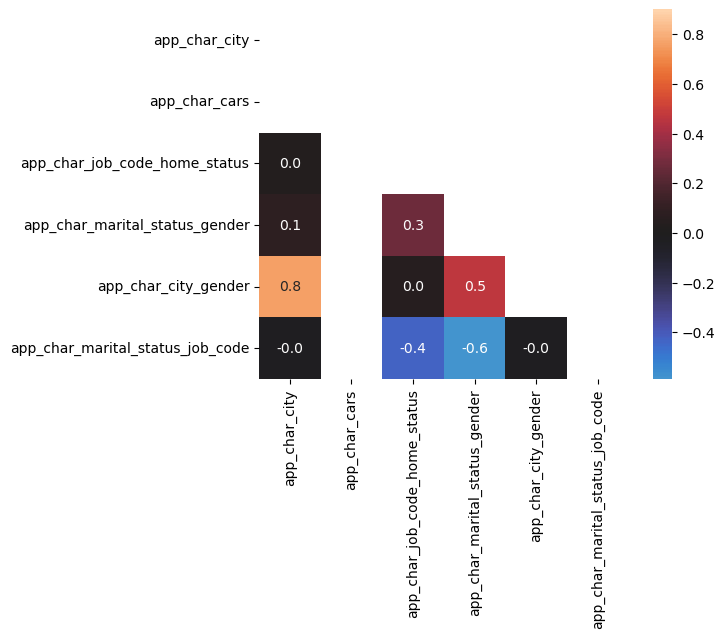

In [2824]:
#plt.subplots(figsize=(20, 10))
#corr_df=df.corr()
#heatmap_df = corr_df.drop(varsn).drop(varsn,axis=1)
# Generate a mask for the upper triangle
corr = train_grp[varsc].dropna()
corr = corr.corr()
mask = np.zeros_like(corr, dtype='bool')
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, vmax=.9, square=True, annot=True, fmt='.1f', center=0)
#sns.heatmap(df.corr(), vmax=.9, square=True, annot=True, fmt='.1f', center=0)
plt.show()
#check

In [2825]:
#Creating Big_scorecard
Big_scorecard=pd.DataFrame()
sum=train_grp.shape[0]
sum_bad=train_grp[target_name].sum()
sum_good=sum-sum_bad

for feature in varsn:
    fin=pd.DataFrame()
    sss=pd.DataFrame()
    ddd=pd.DataFrame()
    sss=pd.DataFrame(train_grp.groupby(feature).agg({target_name:['sum','count']}))
    sss=pd.DataFrame(sss[target_name])
    sss=sss.reset_index()
    sss=sss.rename(columns={"sum": event_name, "count": all_name, feature:grp_name})
    sss[nonevent_name]=sss[all_name]-sss[event_name]
    sss[event_rate_name]=sss[event_name]/sss[all_name]
    sss[logit_name]=np.log((sss[event_name]+0.0001) / (sss[nonevent_name]+0.0001))
    sss[share_name]=sss[all_name]/sum
    sss[variable_name]=feature    
    ddd=pd.DataFrame({grp_name:range(len(feature_intervalsn[feature])),condition_name:feature_intervalsn[feature]})
    fin=pd.merge(ddd, sss, on=grp_name)
    fin=fin[[variable_name,condition_name,event_rate_name,share_name,all_name,event_name,nonevent_name,logit_name,grp_name]]
    fin=fin.sort_values(by=[event_rate_name],ascending=category_order)
    fin=fin.reset_index(drop=True)
    fin[grp_name]=fin.index
    fin[type_name]='INT'
    #zmiana
    #Big_scorecard=Big_scorecard.append(fin,ignore_index=True, sort=False)
    Big_scorecard = pd.concat([Big_scorecard, fin], ignore_index=True, sort=False)
    
for feature in varsc:
    fin=pd.DataFrame()
    sss=pd.DataFrame()
    ddd=pd.DataFrame()
    sss=pd.DataFrame(train_grp.groupby(feature).agg({target_name:['sum','count']}))
    sss=pd.DataFrame(sss[target_name])
    sss=sss.reset_index()
    sss=sss.rename(columns={"sum": event_name, "count": all_name, feature:grp_name})
    sss[nonevent_name]=sss[all_name]-sss[event_name]
    sss[event_rate_name]=sss[event_name]/sss[all_name]
    sss[logit_name]=np.log((sss[event_name]+0.0001) / (sss[nonevent_name]+0.0001))
    sss[share_name]=sss[all_name]/sum
    sss[variable_name]=feature    
    ddd=pd.DataFrame({grp_name:range(len(feature_intervalsc[feature])),condition_name:feature_intervalsc[feature]})
    fin=pd.merge(ddd, sss, on=grp_name)
    fin=fin[[variable_name,condition_name,event_rate_name,share_name,all_name,event_name,nonevent_name,logit_name,grp_name]]
    fin=fin.sort_values(by=[event_rate_name],ascending=category_order)
    fin=fin.reset_index(drop=True)
    fin[grp_name]=fin.index
    fin[type_name]='NOM'
    #zmiana
    #Big_scorecard=Big_scorecard.append(fin,ignore_index=True, sort=False)
    Big_scorecard = pd.concat([Big_scorecard, fin], ignore_index=True, sort=False)

Big_scorecard[bad_share]=Big_scorecard[event_name]/sum_bad
Big_scorecard[good_share]=Big_scorecard[nonevent_name]/sum_good
Big_scorecard[INV]=(Big_scorecard[good_share]-Big_scorecard[bad_share])*np.log((Big_scorecard[good_share]+0.0001) / (Big_scorecard[bad_share]+0.0001))
Big_scorecard.to_excel('Big_scorecard.xlsx', index=False)    
Big_scorecard.head()

,Variable,Condition,BR,Share,All,Bad,Good,Logit,GRP,Type,Bad share,Good share,Infomration Value
0,act_age,act_age < 60.5,0.788301,0.361288,3231,2547.0,684.0,1.314713,0,INT,0.368863,0.335623,0.003138
1,act_age,60.5 <= act_age < 69.5,0.779239,0.314548,2813,2192.0,621.0,1.261238,1,INT,0.317451,0.304711,0.000522
2,act_age,69.5 <= act_age < 74.5,0.768562,0.141563,1266,973.0,293.0,1.200211,2,INT,0.140912,0.143768,0.000057
3,act_age,74.5 <= act_age < 81.5,0.759447,0.121324,1085,824.0,261.0,1.149650,3,INT,0.119334,0.128067,0.000616
4,act_age,81.5 <= act_age,0.673358,0.061277,548,369.0,179.0,0.723411,4,INT,0.053440,0.087831,0.017063


In [2826]:
#Creating grp_train and grp_test
#feature='app_income'
nnn=0
grp_train=train.copy() 
grp_test=test.copy()
#grp_train=train_grp.copy()
#grp_test=test.copy()
for feature in varsn:
    sub=pd.DataFrame()
    sub=Big_scorecard[Big_scorecard[variable_name]==feature]
    sub=sub.reset_index()
    nnn+=1
    print(nnn,feature)
    def grp(x):
        res=sub[grp_name][0]            
        for i in range(sub.shape[0]):
            sl=-np.inf
            sr=np.inf
            fl=sub[condition_name][i].find(' <= ')
            fr=sub[condition_name][i].find(' < ')
            if fl>=0:
                sl=float(sub[condition_name][i][0:fl])
            if fr>=0:
                sr=float(sub[condition_name][i][fr+3:])
            #fnm=condition_name][i].find(' <> '+symbol_missing)
            fm=sub[condition_name][i].find(' = '+symbol_missing) 
            if fm>=0 and math.isnan(x):                
                    res=sub[grp_name][i]            
            if fm<0 and (sl <= x < sr):                
                    res=sub[grp_name][i] 
        return res
    grp_train[feature]=grp_train[feature].apply(grp)
    grp_test[feature]=grp_test[feature].apply(grp)

for feature in varsc:
    sub=pd.DataFrame()
    sub=Big_scorecard[Big_scorecard[variable_name]==feature]
    sub=sub.reset_index()
    nnn+=1
    print(nnn,feature)
    def grp(x):
        res=sub[grp_name][0] 
        if type(x) != str:
            x=str('')
        for i in range(sub.shape[0]):
            fo=sub[condition_name][i].find(symbol_other)
            if fo>=0:                
                    res=sub[grp_name][i]            
        for i in range(sub.shape[0]):
            fo=sub[condition_name][i].find(symbol_other)
            if fo<0 and sub[condition_name][i].find(x)>=0:                
                    res=sub[grp_name][i] 
        return res
    grp_train[feature]=grp_train[feature].apply(grp)
    grp_test[feature]=grp_test[feature].apply(grp)
    
    
grp_train.head() #moze to do 

1 act_age
2 act_cc
3 act_loaninc
4 app_income
5 app_loan_amount
6 app_n_installments
7 app_number_of_children
8 app_spendings
9 app_installment
10 act_call_cc
11 act_cins_n_loan
12 act_ccss_n_loan
13 act_call_n_loan
14 act_cins_seniority
15 act_cins_min_seniority
16 act_cins_n_loans_hist
17 act_cins_n_statC
18 act_cins_n_statB
19 act_cins_n_loans_act
20 act_cins_maxdue
21 act_cins_min_pninst
22 act_cins_min_lninst
23 act_cins_utl
24 act_cins_dueutl
25 act_cins_cc
26 act_ccss_seniority
27 act_ccss_min_seniority
28 act_ccss_n_loans_hist
29 act_ccss_n_statC
30 act_ccss_n_statB
31 act_ccss_n_loans_act
32 act_ccss_maxdue
33 act_ccss_min_pninst
34 act_ccss_min_lninst
35 act_ccss_utl
36 act_ccss_dueutl
37 act_ccss_cc
38 act_cus_active
39 act3_n_arrears
40 act3_n_arrears_days
41 act3_n_good_days
42 act6_n_arrears
43 act6_n_arrears_days
44 act6_n_good_days
45 act9_n_arrears
46 act9_n_arrears_days
47 act9_n_good_days
48 act12_n_arrears
49 act12_n_arrears_days
50 act12_n_good_days
51 app_char_cit

,act_age,act_cc,act_loaninc,app_income,app_loan_amount,app_n_installments,app_number_of_children,app_spendings,app_installment,app_char_city,...,app_char_job_code_home_status,app_char_marital_status_gender,app_char_city_gender,app_char_marital_status_job_code,default_cross12,period,Intercept,outstanding_bad,outstanding,aid
12303,0,2,3,3,0,0,2,3,0,1,...,0,2,2,1,1.0,197711,1,5000.0,5000.0,css1977110500090
32072,0,0,0,0,0,0,0,0,0,0,...,0,2,0,1,1.0,198712,1,5000.0,5000.0,css1987121100097
25756,4,2,3,3,0,0,1,4,0,1,...,0,2,2,1,0.0,198408,1,0.0,5000.0,css1984082500015
19771,1,2,4,4,0,0,1,1,0,1,...,0,2,2,0,1.0,198107,1,5000.0,5000.0,css1981071500007
13862,2,4,4,4,0,0,0,2,0,1,...,0,2,2,1,0.0,197808,1,0.0,5000.0,css1978080600056


In [2827]:
#Creating grp_train and grp_test
#feature='app_income'
nnn=0
grp_train=train.copy()
grp_test=test.copy()
for feature in varsn:
    sub=pd.DataFrame()
    sub=Big_scorecard[Big_scorecard[variable_name]==feature]
    sub=sub.reset_index()
    nnn+=1
    print(nnn,feature)
    def grp(x):
        res=sub[grp_name][0]            
        for i in range(sub.shape[0]):
            sl=-np.inf
            sr=np.inf
            fl=sub[condition_name][i].find(' <= ')
            fr=sub[condition_name][i].find(' < ')
            if fl>=0:
                sl=float(sub[condition_name][i][0:fl])
            if fr>=0:
                sr=float(sub[condition_name][i][fr+3:])
            #fnm=condition_name][i].find(' <> '+symbol_missing)
            fm=sub[condition_name][i].find(' = '+symbol_missing)
            if fm>=0 and math.isnan(x):                
                    res=sub[grp_name][i]            
            if fm<0 and (sl <= x < sr):                
                    res=sub[grp_name][i] 
        return res
    grp_train[feature]=grp_train[feature].apply(grp)
    grp_test[feature]=grp_test[feature].apply(grp)

for feature in varsc:
    sub=pd.DataFrame()
    sub=Big_scorecard[Big_scorecard[variable_name]==feature]
    sub=sub.reset_index()
    nnn+=1
    print(nnn,feature)
    def grp(x):
        res=sub[grp_name][0] 
        if type(x) != str:
            x=str('')
        for i in range(sub.shape[0]):
            fo=sub[condition_name][i].find(symbol_other)
            if fo>=0:                
                    res=sub[grp_name][i]            
        for i in range(sub.shape[0]):
            fo=sub[condition_name][i].find(symbol_other)
            if fo<0 and sub[condition_name][i].find(x)>=0:                
                    res=sub[grp_name][i] 
        return res
    grp_train[feature]=grp_train[feature].apply(grp)
    grp_test[feature]=grp_test[feature].apply(grp)
    
    
grp_train.head()

1 act_age
2 act_cc
3 act_loaninc
4 app_income
5 app_loan_amount
6 app_n_installments
7 app_number_of_children
8 app_spendings
9 app_installment
10 act_call_cc
11 act_cins_n_loan
12 act_ccss_n_loan
13 act_call_n_loan
14 act_cins_seniority
15 act_cins_min_seniority
16 act_cins_n_loans_hist
17 act_cins_n_statC
18 act_cins_n_statB
19 act_cins_n_loans_act
20 act_cins_maxdue
21 act_cins_min_pninst
22 act_cins_min_lninst
23 act_cins_utl
24 act_cins_dueutl
25 act_cins_cc
26 act_ccss_seniority
27 act_ccss_min_seniority
28 act_ccss_n_loans_hist
29 act_ccss_n_statC
30 act_ccss_n_statB
31 act_ccss_n_loans_act
32 act_ccss_maxdue
33 act_ccss_min_pninst
34 act_ccss_min_lninst
35 act_ccss_utl
36 act_ccss_dueutl
37 act_ccss_cc
38 act_cus_active
39 act3_n_arrears
40 act3_n_arrears_days
41 act3_n_good_days
42 act6_n_arrears
43 act6_n_arrears_days
44 act6_n_good_days
45 act9_n_arrears
46 act9_n_arrears_days
47 act9_n_good_days
48 act12_n_arrears
49 act12_n_arrears_days
50 act12_n_good_days
51 app_char_cit

,act_age,act_cc,act_loaninc,app_income,app_loan_amount,app_n_installments,app_number_of_children,app_spendings,app_installment,app_char_city,...,app_char_job_code_home_status,app_char_marital_status_gender,app_char_city_gender,app_char_marital_status_job_code,default_cross12,period,Intercept,outstanding_bad,outstanding,aid
12303,0,2,3,3,0,0,2,3,0,1,...,0,2,2,1,1.0,197711,1,5000.0,5000.0,css1977110500090
32072,0,0,0,0,0,0,0,0,0,0,...,0,2,0,1,1.0,198712,1,5000.0,5000.0,css1987121100097
25756,4,2,3,3,0,0,1,4,0,1,...,0,2,2,1,0.0,198408,1,0.0,5000.0,css1984082500015
19771,1,2,4,4,0,0,1,1,0,1,...,0,2,2,0,1.0,198107,1,5000.0,5000.0,css1981071500007
13862,2,4,4,4,0,0,0,2,0,1,...,0,2,2,1,0.0,197808,1,0.0,5000.0,css1978080600056


In [2828]:
#Creating Big_scorecard test
Big_scorecard_test=pd.DataFrame()
sum=grp_test.shape[0]
sum_bad=grp_test[target_name].sum()

for feature in vars:
    sss=pd.DataFrame()
    sss=pd.DataFrame(grp_test.groupby(feature).agg({target_name:['sum','count']}))
    sss=pd.DataFrame(sss[target_name])
    sss=sss.reset_index()
    sss=sss.rename(columns={"sum": event_name, "count": all_name, feature:grp_name})
    sss[nonevent_name]=sss[all_name]-sss[event_name]
    sss[share_name_test]=sss[all_name]/sum
    sss[bad_share_test]=sss[event_name]/sum_bad
    sss[variable_name]=feature
    sss=sss[[variable_name,grp_name,share_name_test,bad_share_test]]
    #zmiana
    #Big_scorecard_test=Big_scorecard_test.append(sss,ignore_index=True, sort=False)
    Big_scorecard_test = pd.concat([Big_scorecard_test, sss], ignore_index=True, sort=False)
    

Big_scorecard_test.head()

,Variable,GRP,Share test,Bad share test
0,act_age,0,0.352987,0.368665
1,act_age,1,0.322724,0.316330
2,act_age,2,0.140882,0.139781
3,act_age,3,0.123924,0.120238
4,act_age,4,0.059483,0.054985


In [2829]:
Big_scorecard

,Variable,Condition,BR,Share,All,Bad,Good,Logit,GRP,Type,Bad share,Good share,Infomration Value
0,act_age,act_age < 60.5,0.788301,0.361288,3231,2547.0,684.0,1.314713,0,INT,0.368863,0.335623,0.003138
1,act_age,60.5 <= act_age < 69.5,0.779239,0.314548,2813,2192.0,621.0,1.261238,1,INT,0.317451,0.304711,0.000522
2,act_age,69.5 <= act_age < 74.5,0.768562,0.141563,1266,973.0,293.0,1.200211,2,INT,0.140912,0.143768,0.000057
3,act_age,74.5 <= act_age < 81.5,0.759447,0.121324,1085,824.0,261.0,1.149650,3,INT,0.119334,0.128067,0.000616
4,act_age,81.5 <= act_age,0.673358,0.061277,548,369.0,179.0,0.723411,4,INT,0.053440,0.087831,0.017063
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,app_char_city_gender,<OTHERS>,0.777805,0.463491,4145,3224.0,921.0,1.252918,1,NOM,0.466908,0.451914,0.000489
200,app_char_city_gender,BigFemale,0.741765,0.274964,2459,1824.0,635.0,1.055162,2,NOM,0.264156,0.311580,0.007828
201,app_char_marital_status_job_code,DivorcedRetired,0.867147,0.170860,1528,1325.0,203.0,1.875961,0,NOM,0.191890,0.099607,0.060464
202,app_char_marital_status_job_code,"MariedPermanent, MariedRetired",0.744971,0.466957,4176,3111.0,1065.0,1.071969,1,NOM,0.450543,0.522571,0.010680


In [2830]:
#calculating PSI INV
Big_scorecard=pd.merge(Big_scorecard, Big_scorecard_test, on=[variable_name,grp_name], how='left')
Big_scorecard[PSI]=(Big_scorecard[share_name]-Big_scorecard[share_name_test])*np.log((Big_scorecard[share_name]+0.0001) / (Big_scorecard[share_name_test]+0.0001))
Big_scorecard[PSI_tar]=(Big_scorecard[bad_share]-Big_scorecard[bad_share_test])*np.log((Big_scorecard[bad_share]+0.0001) / (Big_scorecard[bad_share_test]+0.0001))

Big_scorecard.head()

,Variable,Condition,BR,Share,All,Bad,Good,Logit,GRP,Type,Bad share,Good share,Infomration Value,Share test,Bad share test,Population Stability Index,Population Stability Index for bads
0,act_age,act_age < 60.5,0.788301,0.361288,3231,2547.0,684.0,1.314713,0,INT,0.368863,0.335623,0.003138,0.352987,0.368665,0.000193,1.063064e-07
1,act_age,60.5 <= act_age < 69.5,0.779239,0.314548,2813,2192.0,621.0,1.261238,1,INT,0.317451,0.304711,0.000522,0.322724,0.316330,0.000210,3.965788e-06
2,act_age,69.5 <= act_age < 74.5,0.768562,0.141563,1266,973.0,293.0,1.200211,2,INT,0.140912,0.143768,0.000057,0.140882,0.139781,0.000003,9.107805e-06
3,act_age,74.5 <= act_age < 81.5,0.759447,0.121324,1085,824.0,261.0,1.149650,3,INT,0.119334,0.128067,0.000616,0.123924,0.120238,0.000055,6.826793e-06
4,act_age,81.5 <= act_age,0.673358,0.061277,548,369.0,179.0,0.723411,4,INT,0.053440,0.087831,0.017063,0.059483,0.054985,0.000053,4.398469e-05


In [2831]:
# #zmiana
# def grp(x):
#     res=sub[logit_name][0]
#     fm=None
#     for i in range(sub.shape[0]):
#         sl=-np.inf
#         sr=np.inf
#         fl=sub[condition_name][i].find(' <= ')
#         fr=sub[condition_name][i].find(' < ')
#         if fl>=0:
#             sl=float(sub[condition_name][i][0:fl])
#         if fr>=0:
#             sr=float(sub[condition_name][i][fr+3:])
#             #fnm=condition_name][i].find(' <> '+symbol_missing)
#             fm=sub[condition_name][i].find(' = '+symbol_missing)
#         if fm>=0 and math.isnan(x):     
#             res=sub[logit_name][i]            
#         if fm<0 and (sl <= x < sr):
#             res=sub[logit_name][i] 
#     return res

In [2832]:
# #Creating logit_train and logit_test
# #feature='app_income'
# nnn=0
# logit_train=train.copy()
# logit_test=test.copy()
# for feature in varsn:
#     sub=pd.DataFrame()
#     sub=Big_scorecard[Big_scorecard[variable_name]==feature]
#     sub=sub.reset_index()
#     nnn+=1
#     print(nnn,feature)
#     def grp(x):
#         res=sub[logit_name][0]            
#         for i in range(sub.shape[0]):
#             sl=-np.inf
#             sr=np.inf
#             fl=sub[condition_name][i].find(' <= ')
#             fr=sub[condition_name][i].find(' < ')
#             if fl>=0:
#                 sl=float(sub[condition_name][i][0:fl])
#             if fr>=0:
#                 sr=float(sub[condition_name][i][fr+3:])
#             #fnm=condition_name][i].find(' <> '+symbol_missing)
#             fm=sub[condition_name][i].find(' = '+symbol_missing)
#             if fm>=0 and math.isnan(x):                
#                     res=sub[logit_name][i]            
#             if fm<0 and (sl <= x < sr):                
#                     res=sub[logit_name][i] 
#         return res
#     logit_train[feature]=logit_train[feature].apply(grp)
#     logit_test[feature]=logit_test[feature].apply(grp)

# for feature in varsc:
#     sub=pd.DataFrame()
#     sub=Big_scorecard[Big_scorecard[variable_name]==feature]
#     sub=sub.reset_index()
#     nnn+=1
#     print(nnn,feature)
#     def grp(x):
#         res=sub[logit_name][0] 
#         if type(x) != str:
#             x=str('')
#         for i in range(sub.shape[0]):
#             fo=sub[condition_name][i].find(symbol_other)
#             if fo>=0:                
#                     res=sub[logit_name][i]            
#         for i in range(sub.shape[0]):
#             fo=sub[condition_name][i].find(symbol_other)
#             if fo<0 and sub[condition_name][i].find(x)>=0:                
#                     res=sub[logit_name][i] 
#         return res
#     logit_train[feature]=logit_train[feature].apply(grp)
#     logit_test[feature]=logit_test[feature].apply(grp)
    
    
# logit_train.head()

In [2833]:
def grp(x, sub):
    res=sub[logit_name][0]            
    for i in range(sub.shape[0]):
        sl=-np.inf
        sr=np.inf
        fl=sub[condition_name][i].find(' <= ')
        fr=sub[condition_name][i].find(' < ')
        if fl>=0:
            sl=float(sub[condition_name][i][0:fl])
        if fr>=0:
            sr=float(sub[condition_name][i][fr+3:])
        #fnm=condition_name][i].find(' <> '+symbol_missing)
        fm=sub[condition_name][i].find(' = '+symbol_missing)
        if fm>=0 and math.isnan(x):                
                res=sub[logit_name][i]            
        if fm<0 and (sl <= x < sr):                
                res=sub[logit_name][i] 
    return res

nnn = 0
logit_train = train.copy()
logit_test = test.copy()
for feature in varsn:
    sub = Big_scorecard[Big_scorecard[variable_name] == feature]
    sub = sub.reset_index()
    logit_train[feature] = logit_train[feature].apply(lambda x: grp(x, sub))
    logit_test[feature] = logit_test[feature].apply(lambda x: grp(x, sub))

def grp(x, sub):
    res=sub[logit_name][0] 
    if type(x) != str:
        x=str('')
    for i in range(sub.shape[0]):
        fo=sub[condition_name][i].find(symbol_other)
        if fo>=0:                
                res=sub[logit_name][i]            
    for i in range(sub.shape[0]):
        fo=sub[condition_name][i].find(symbol_other)
        if fo<0 and sub[condition_name][i].find(x)>=0:                
                res=sub[logit_name][i] 
    return res

for feature in varsc:
    sub = Big_scorecard[Big_scorecard[variable_name] == feature]
    sub = sub.reset_index()
    logit_train[feature] = logit_train[feature].apply(lambda x: grp(x, sub))
    logit_test[feature] = logit_test[feature].apply(lambda x: grp(x, sub))
    
logit_train.head()

,act_age,act_cc,act_loaninc,app_income,app_loan_amount,app_n_installments,app_number_of_children,app_spendings,app_installment,app_char_city,...,app_char_job_code_home_status,app_char_marital_status_gender,app_char_city_gender,app_char_marital_status_job_code,default_cross12,period,Intercept,outstanding_bad,outstanding,aid
12303,1.314713,1.386294,1.085491,1.138803,1.220277,1.220277,0.440570,1.053899,1.220277,1.133967,...,1.298579,1.012261,1.055162,1.071969,1.0,197711,1,5000.0,5000.0,css1977110500090
32072,1.314713,3.164063,3.065065,3.065065,1.220277,1.220277,1.778576,2.199105,1.220277,1.458865,...,1.298579,1.012261,1.348773,1.071969,1.0,198712,1,5000.0,5000.0,css1987121100097
25756,0.723411,1.386294,1.085491,1.138803,1.220277,1.220277,1.171794,0.399273,1.220277,1.133967,...,1.298579,1.012261,1.055162,1.071969,0.0,198408,1,0.0,5000.0,css1984082500015
19771,1.261238,1.386294,0.863265,0.841801,1.220277,1.220277,1.171794,1.478449,1.220277,1.133967,...,1.298579,1.012261,1.055162,1.875961,1.0,198107,1,5000.0,5000.0,css1981071500007
13862,1.200211,0.598709,0.863265,0.841801,1.220277,1.220277,1.778576,1.159974,1.220277,1.133967,...,1.298579,1.012261,1.055162,1.071969,0.0,197808,1,0.0,5000.0,css1978080600056


In [2834]:
train

,act_age,act_cc,act_loaninc,app_income,app_loan_amount,app_n_installments,app_number_of_children,app_spendings,app_installment,app_char_city,...,app_char_job_code_home_status,app_char_marital_status_gender,app_char_city_gender,app_char_marital_status_job_code,default_cross12,period,Intercept,outstanding_bad,outstanding,aid
12303,50.0,0.571429,4.152824,1204.0,5000.0,24.0,2.0,480.0,208.0,Big,...,RetiredOwner,MariedFemale,BigFemale,MariedRetired,1.0,197711,1,5000.0,5000.0,css1977110500090
32072,54.0,0.968326,11.312217,442.0,5000.0,24.0,0.0,220.0,208.0,Medium,...,RetiredOwner,MariedFemale,MediumFemale,MariedRetired,1.0,198712,1,5000.0,5000.0,css1987121100097
25756,88.0,0.605607,4.672897,1070.0,5000.0,24.0,1.0,440.0,208.0,Big,...,RetiredOwner,MariedFemale,BigFemale,MariedRetired,0.0,198408,1,0.0,5000.0,css1984082500015
19771,63.0,0.518636,1.982554,2522.0,5000.0,24.0,1.0,1100.0,208.0,Big,...,ContractOwner,MariedFemale,BigFemale,MariedContract,1.0,198107,1,5000.0,5000.0,css1981071500007
13862,73.0,0.434596,3.573981,1399.0,5000.0,24.0,0.0,400.0,208.0,Big,...,RetiredRental,MariedFemale,BigFemale,MariedRetired,0.0,197808,1,0.0,5000.0,css1978080600056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29573,75.0,0.614098,2.986858,1674.0,5000.0,24.0,0.0,820.0,208.0,Small,...,RetiredOwner,WidowedFemale,SmallFemale,WidowedRetired,1.0,198608,1,5000.0,5000.0,css1986082400088
21048,59.0,0.317164,0.687096,7277.0,5000.0,24.0,2.0,2100.0,208.0,Large,...,Owner companyOwner,DivorcedFemale,LargeFemale,DivorcedOwner company,1.0,198203,1,5000.0,5000.0,css1982030800024
9205,67.0,0.488136,8.474576,590.0,5000.0,24.0,0.0,80.0,208.0,Medium,...,RetiredOwner,MariedFemale,MediumFemale,MariedRetired,1.0,197604,1,5000.0,5000.0,css1976042200011
24513,62.0,0.475443,0.852660,5864.0,5000.0,24.0,0.0,2580.0,208.0,Small,...,Owner companyOwner,MariedMale,SmallMale,MariedOwner company,1.0,198312,1,5000.0,5000.0,css1983122600002


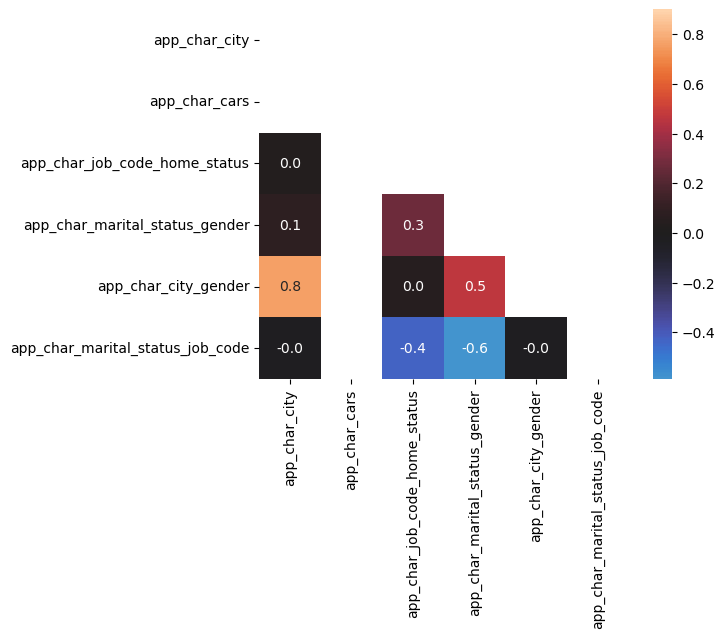

In [2835]:
#plt.subplots(figsize=(20, 10))
#corr_df=df.corr()
#heatmap_df = corr_df.drop(varsn).drop(varsn,axis=1)
# Generate a mask for the upper triangle
corr = train_grp[varsc].dropna()
corr = corr.corr()
mask = np.zeros_like(corr, dtype='bool')
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, vmax=.9, square=True, annot=True, fmt='.1f', center=0)
#sns.heatmap(df.corr(), vmax=.9, square=True, annot=True, fmt='.1f', center=0)
plt.show()
#check

In [2836]:
# #Calculating Gini values for features
#zmiana
# #feature='app_const'
# Gini_vars=pd.DataFrame()
# #from sklearn import metrics
# for feature in vars:
#     sss=pd.DataFrame([feature], columns=[variable_name])
#     fpr, tpr, thresholds = metrics.roc_curve(logit_train[target_name], logit_train[feature])
#     gini=np.absolute(2*metrics.auc(fpr, tpr)-1)
#     sss[gini_train]=gini
#     fpr, tpr, thresholds = metrics.roc_curve(logit_test[target_name], logit_test[feature])
#     gini=np.absolute(2*metrics.auc(fpr, tpr)-1)
#     sss[gini_test]=gini
#     #zmiana przez The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead
#     #Gini_vars=Gini_vars.append(sss,ignore_index=True, sort=False)
#     Gini_vars = pd.concat([Gini_vars, sss], ignore_index=True)
    
# Gini_vars[delta_gini]=np.absolute(Gini_vars[gini_train]-Gini_vars[gini_test])/Gini_vars[gini_train]
# Gini_vars[delta_gini]=Gini_vars[delta_gini].fillna(0)
# Gini_vars=Gini_vars.sort_values(by=[gini_train],ascending=False)
# Gini_vars=Gini_vars.reset_index(drop=True)


In [2837]:
def calculate_gini_train_test_r(logit_train=logit_train, logit_test=logit_test, target_name=target_name, vars=vars):
    Gini_vars = pd.DataFrame()
    for feature in vars:
        sss = pd.DataFrame([feature], columns=[variable_name])
        fpr, tpr, thresholds = metrics.roc_curve(logit_train[target_name], logit_train[feature])
        gini = np.absolute(2*metrics.auc(fpr, tpr)-1)
        sss[gini_train] = gini
        fpr, tpr, thresholds = metrics.roc_curve(logit_test[target_name], logit_test[feature])
        gini = np.absolute(2*metrics.auc(fpr, tpr)-1)
        sss[gini_test] = gini
        Gini_vars = pd.concat([Gini_vars, sss], ignore_index=True)

    Gini_vars[delta_gini] = np.absolute(Gini_vars[gini_train]-Gini_vars[gini_test])/Gini_vars[gini_train]
    Gini_vars[delta_gini] = Gini_vars[delta_gini].fillna(0)
    Gini_vars = Gini_vars.sort_values(by=[gini_train],ascending=False)
    Gini_vars = Gini_vars.reset_index(drop=True)
    return Gini_vars

In [2838]:
Gini_vars = calculate_gini_train_test_r()
Gini_vars.head(2)

,Variable,Gini train,Gini test,R. Gini
0,act_ccss_n_statC,0.525641,0.500844,0.047175
1,act_ccss_n_loans_act,0.447709,0.396832,0.113640


In [2839]:
#zmiana
# sss=pd.DataFrame(Big_scorecard.groupby(variable_name).agg({INV:['sum'],PSI:['sum'],PSI_tar:['sum']}))
# sss.columns=[INV,PSI,PSI_tar]
# sss=sss.reset_index()

In [2840]:
def gini_compute_aggregate_values(Big_scorecard = Big_scorecard, vars = vars):
    sss=pd.DataFrame(Big_scorecard.groupby(variable_name).agg({INV:['sum'],PSI:['sum'],PSI_tar:['sum']}))
    sss.columns=[INV,PSI,PSI_tar]
    sss=sss.reset_index()
    return sss

In [2841]:
sss = gini_compute_aggregate_values()
sss.head(3)

,Variable,Infomration Value,Population Stability Index,Population Stability Index for bads
0,act12_n_arrears,0.505307,0.000213,0.000340
1,act12_n_arrears_days,0.113594,0.002372,0.003585
2,act12_n_good_days,0.490052,0.003389,0.003598


In [2842]:
#zmiana
# pm = train[vars].isnull().sum() / len(train)
# stat = pd.DataFrame({'percent_missing': pm}).reset_index()
# stat.columns=[variable_name,percent_missing]
# stat[count_unique]=0
# for i in range(stat.shape[0]):
#     #zmiana See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
#     #stat[count_unique][i]=len(pd.unique(train[stat[variable_name][i]]))
#     stat.loc[i, count_unique] = train[stat.loc[i, variable_name]].nunique()

In [2843]:
def gini_compute_missing_values(train=train, vars=vars):
    pm = train[vars].isnull().sum() / len(train)
    stat = pd.DataFrame({'percent_missing': pm}).reset_index()
    stat.columns=[variable_name,percent_missing]
    stat[count_unique]=0
    for i in range(stat.shape[0]):
        stat.loc[i, count_unique] = train[stat.loc[i, variable_name]].nunique()
    return stat

In [2844]:
stat = gini_compute_missing_values()

In [2845]:
Gini_vars=pd.merge(Gini_vars, sss, on=variable_name)
Gini_vars=pd.merge(Gini_vars, stat, on=variable_name)

fin=pd.DataFrame()
# feature='ags6_Iqr_Cncr'
# feature='app_char_job_code'
for feature in vars:
    row=pd.DataFrame(np.array([[1,2,3,4]]),columns=[variable_name,mode_name,mode_pname,type_name])
    row[variable_name]=feature

    ttt=train[[feature]].copy()
    ttt=ttt[ttt[feature].isnull()==False]
    pm2=ttt[feature].mode()
    row[mode_name]=pm2[0]

    ttt2=pd.DataFrame(ttt.groupby(feature)[feature].count()/ttt.shape[0])
    ttt2.columns=['count']
    ttt2=ttt2.reset_index()
    ttt2.columns=['var','count']
    ttt2=ttt2[ttt2['var']==pm2[0]]
    ttt2=ttt2.reset_index()
    row[mode_pname]=ttt2['count'][0]
    row[type_name]='INT'
    for f2 in varsc: 
        if f2==feature: row[type_name]='NOM'
            
    #zmiana
    #fin=fin.append(row, ignore_index=True, sort=False)
    fin = pd.concat([fin, row], ignore_index=True)

Gini_vars=pd.merge(Gini_vars, fin, on=variable_name)

Gini_vars.to_excel('Gini_vars.xlsx', index=False) 
Gini_vars.head()

,Variable,Gini train,Gini test,R. Gini,Infomration Value,Population Stability Index,Population Stability Index for bads,Missing percent,Number of distinct,Mode,P. mode,Type
0,act_ccss_n_statC,0.525641,0.500844,0.047175,1.425280,0.001637,0.000278,0.00000,46,0.0,0.227664,INT
1,act_ccss_n_loans_act,0.447709,0.396832,0.113640,0.969068,0.002150,0.002411,0.00246,6,3.0,0.261181,INT
2,act_ccss_maxdue,0.441160,0.461705,0.046572,0.801669,0.000875,0.000352,0.00246,8,0.0,0.200986,INT
3,act_ccss_utl,0.439472,0.439814,0.000778,0.862046,0.000499,0.000771,0.00246,137,0.541667,0.071180,INT
4,act_ccss_min_pninst,0.413943,0.430055,0.038923,0.621269,0.001225,0.001144,0.00246,24,0.0,0.282367,INT


In [2846]:
#Calculating Gini values for features


In [2847]:
print(Gini_vars[gini_train].describe())

count    56.000000
mean      0.182711
std       0.158152
min       0.000000
25%       0.028297
50%       0.168270
75%       0.315121
max       0.525641
Name: Gini train, dtype: float64


In [2848]:
print(Gini_vars[delta_gini].describe())


count    56.000000
mean      0.353736
std       1.186701
min       0.000000
25%       0.017089
50%       0.084568
75%       0.193634
max       8.388907
Name: R. Gini, dtype: float64


In [2849]:
print(Gini_vars[PSI_tar].describe())


count    56.000000
mean      0.288459
std       0.815155
min       0.000000
25%       0.000325
50%       0.001094
75%       0.002869
max       3.570910
Name: Population Stability Index for bads, dtype: float64


In [2850]:
print(Gini_vars[PSI].describe())

count    56.000000
mean      0.297136
std       0.838942
min       0.000000
25%       0.000491
50%       0.001153
75%       0.003583
max       3.684031
Name: Population Stability Index, dtype: float64


In [2851]:
Gini_vars[PSI].quantile(.25)

0.0004909156468822042

In [2852]:
#zmiana
#description_results += " Gini_vars=default "
description_results += "Gini_vars[gini_train]>0.06, Gini_vars[delta_gini]<0.3; "
#todo
sub=Gini_vars[
    (Gini_vars[gini_train]>0.06) #0.05
    & (Gini_vars[delta_gini]<0.3) #<0.2
    & (Gini_vars[PSI_tar]<0.1)
    & (Gini_vars[PSI]<0.1)
].copy()
# sub=Gini_vars[
#     (Gini_vars[gini_train]>Gini_vars[gini_train].quantile(.25)) 
#     & (Gini_vars[delta_gini]<Gini_vars[delta_gini].quantile(.25)) #<0.2
#     & (Gini_vars[PSI_tar]<0.1)
#     & (Gini_vars[PSI]<0.1)
# ].copy()

vars_selected=list(sub[variable_name])
# vars_selected.remove('act_state_7_CMax_Due')
# vars_selected.remove('ags6_Iqr_Cncr')
# vars_selected.remove('ags9_Min_CMin_Days')



print(len(list(vars_selected)))
vars_selected

35


['act_ccss_n_statC',
 'act_ccss_n_loans_act',
 'act_ccss_maxdue',
 'act_ccss_utl',
 'act_ccss_min_pninst',
 'act_ccss_n_loan',
 'act3_n_arrears',
 'act6_n_arrears',
 'act_ccss_n_loans_hist',
 'act_call_n_loan',
 'act_ccss_min_lninst',
 'act9_n_arrears',
 'act12_n_good_days',
 'act12_n_arrears',
 'act9_n_good_days',
 'app_number_of_children',
 'act_cc',
 'app_income',
 'act6_n_good_days',
 'act_loaninc',
 'act_ccss_seniority',
 'act_ccss_n_statB',
 'act_cins_min_seniority',
 'app_spendings',
 'act_ccss_dueutl',
 'app_char_marital_status_gender',
 'act12_n_arrears_days',
 'act3_n_good_days',
 'act9_n_arrears_days',
 'act6_n_arrears_days',
 'act_cins_seniority',
 'app_char_marital_status_job_code',
 'act_cins_n_statC',
 'act_call_cc',
 'act_cins_n_loans_hist']

In [2853]:
#Creating full data
#zmiana
#grp_all=grp_train.append(grp_test, ignore_index=True, sort=False)
grp_all = pd.concat([grp_train, grp_test], ignore_index=True, sort=False)
print(grp_all.shape, train.shape, test.shape)

#grp_all.head()

(12776, 62) (8943, 62) (3833, 62)


In [2854]:
print(grp_all.columns)

Index(['act_age', 'act_cc', 'act_loaninc', 'app_income', 'app_loan_amount',
       'app_n_installments', 'app_number_of_children', 'app_spendings',
       'app_installment', 'app_char_city', 'app_char_cars', 'act_call_cc',
       'act_cins_n_loan', 'act_ccss_n_loan', 'act_call_n_loan',
       'act_cins_seniority', 'act_cins_min_seniority', 'act_cins_n_loans_hist',
       'act_cins_n_statC', 'act_cins_n_statB', 'act_cins_n_loans_act',
       'act_cins_maxdue', 'act_cins_min_pninst', 'act_cins_min_lninst',
       'act_cins_utl', 'act_cins_dueutl', 'act_cins_cc', 'act_ccss_seniority',
       'act_ccss_min_seniority', 'act_ccss_n_loans_hist', 'act_ccss_n_statC',
       'act_ccss_n_statB', 'act_ccss_n_loans_act', 'act_ccss_maxdue',
       'act_ccss_min_pninst', 'act_ccss_min_lninst', 'act_ccss_utl',
       'act_ccss_dueutl', 'act_ccss_cc', 'act_cus_active', 'act3_n_arrears',
       'act3_n_arrears_days', 'act3_n_good_days', 'act6_n_arrears',
       'act6_n_arrears_days', 'act6_n_good_days',

In [2855]:
#Creating time variable
#zmiana -  PerformanceWarning: DataFrame is highly fragmented.  
#grp_all[time_report_name]=grp_all[time_name].astype(str).str[0:4]
grp_all = grp_all.copy()
grp_all[time_report_name] = grp_all[time_name].astype(str).str[0:4]
grp_all[[time_name, time_report_name]].head()

,period,Time
0,197711,1977
1,198712,1987
2,198408,1984
3,198107,1981
4,197808,1978


In [2856]:
#import xlsxwriter

In [2857]:
#Variable_report
startrow=2

# Dump Pandas DataFrame to Excel sheet
writer = pd.ExcelWriter('Variable_report.xlsx', engine='xlsxwriter')
Gini_vars.to_excel(writer, sheet_name=variable_name, startrow=1, index_label=None, index=False)

series = Gini_vars[variable_name]
max_len = max((series.astype(str).map(len).max(),len(str(series.name)))) + 1 

book = writer.book
sheet = writer.sheets[variable_name]
#format1 = workbook.add_format({'num_format': '#,##0.00'})
format1 = book.add_format({'num_format': '0.0%'})
sheet.set_column('B:B', None, format1)
sheet.set_column('C:C', None, format1)
sheet.set_column('D:D', None, format1)
sheet.set_column(0,0, max_len)
sheet.set_column(1,1,len(gini_train))
sheet.set_column(2,2,len(gini_test))
sheet.set_column(3,3,len(delta_gini))
sheet.set_column(4,4,len(INV))
sheet.set_column(5,5,len(PSI))
sheet.set_column(6,6,len(PSI_tar))
sheet.set_column(7,7,len(percent_missing))
sheet.set_column(8,8,len(count_unique))

sss2=pd.DataFrame(grp_all[time_report_name].value_counts())
ntimes=sss2.shape[0]
    
    
for feature in vars_selected: 
    sssgr=pd.DataFrame(grp_all.groupby([time_report_name]).agg({target_name:['count']}))
    sssgr=pd.DataFrame(sssgr[target_name])
    sssgr=sssgr.reset_index()
    fin=pd.DataFrame()
    sss=pd.DataFrame()
    ddd=pd.DataFrame()
    sss=pd.DataFrame(grp_all.groupby([feature,time_report_name]).agg({target_name:['sum','count']}))
    sss=pd.DataFrame(sss[target_name])
    sss=sss.reset_index()
    sss=sss.rename(columns={"sum": event_name, "count": all_name, feature:grp_name})
    sss=pd.merge(sss, sssgr, on=time_report_name)
    sss[nonevent_name]=sss[all_name]-sss[event_name]
    sss[event_rate_name]=sss[event_name]/sss[all_name]
    sss[share_name]=sss[all_name]/sss["count"]
    sss=sss[[grp_name,time_report_name,event_name,all_name,nonevent_name,event_rate_name,share_name]]
    sss=sss.sort_values(by=[grp_name,time_report_name])
    
    sub=Big_scorecard[Big_scorecard[variable_name]==feature]
    sub=sub[[grp_name,condition_name,event_rate_name,share_name,all_name,event_name,nonevent_name]]
    ncat=sub.shape[0]
    
    shname=feature[0:31]
    sub.to_excel(writer, sheet_name=shname, startrow=startrow, index_label=None, index=False)
    sss.to_excel(writer, sheet_name=shname, startrow=startrow, index_label=None, index=False, startcol=8)
    book = writer.book
    sheet = writer.sheets[shname]
    bold = book.add_format({'bold': True, 'size': 24})
    sheet.write('A1', variable_name+': '+feature, bold)
    bold = book.add_format({'bold': True, 'size': 12})
    boldp = book.add_format({'bold': True, 'size': 12, 'num_format': '0.0%'})
    sheet.write_formula('D'+str(startrow+ncat+2), '=SUM(D4:D'+str(startrow+ncat+1)+')', boldp)
    sheet.write_formula('E'+str(startrow+ncat+2), '=SUM(E4:E'+str(startrow+ncat+1)+')', bold)
    sheet.write_formula('F'+str(startrow+ncat+2), '=SUM(F4:F'+str(startrow+ncat+1)+')', bold)
    sheet.write_formula('G'+str(startrow+ncat+2), '=SUM(G4:G'+str(startrow+ncat+1)+')', bold)

    #format1 = workbook.add_format({'num_format': '#,##0.00'})
    format1 = book.add_format({'num_format': '0.0%'})
    sheet.set_column('C:C', None, format1)
    sheet.set_column('D:D', None, format1)
    sheet.set_column('N:N', None, format1)
    sheet.set_column('O:O', None, format1)

    series = sub[condition_name]
    max_len = max((series.astype(str).map(len).max(),len(str(series.name)))) + 1
    sheet.set_column(1,1,max_len)

    # Chart
    chart = book.add_chart({'type': 'line'})
    chart.set_title({'name': event_rate_name})
    chart.set_x_axis({'name': '='+shname+'!J3', 'num_font':  {'rotation': 45}})
    for i in range(ncat):
        chart.add_series({'values': '='+shname+'!N'+str(4+i*ntimes)+':N'+str(4+(i+1)*ntimes-1), 'name': '='+shname+'!I'+str(4+i*ntimes),
                         'categories': '='+shname+'!J'+str(4)+':J'+str(4+ntimes-1)})
    chart.set_legend({'position': 'bottom'})
    sheet.insert_chart('A'+str(ncat+6), chart)


    chart = book.add_chart({'type': 'line'})
    chart.set_title({'name': share_name})
    chart.set_x_axis({'name': '='+shname+'!J3', 'num_font':  {'rotation': 45}})
    for i in range(ncat):
        chart.add_series({'values': '='+shname+'!O'+str(4+i*ntimes)+':O'+str(4+(i+1)*ntimes-1), 'name': '='+shname+'!I'+str(4+i*ntimes),
                         'categories': '='+shname+'!J'+str(4)+':J'+str(4+ntimes-1)})
    chart.set_legend({'position': 'bottom'})
    sheet.insert_chart('A'+str(ncat+6+18), chart)
#zmiana
#writer.save()
#writer.close()

In [2858]:
#!pip3 install statsmodels check

In [2859]:
#Simple RFE selection method
#description_results += " LogisticRegression:solver='lbfgs -"
#model = LogisticRegression(solver='lbfgs', multi_class='auto',max_iter=1000) #zamiana
model = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000) #zmiana
rfe = RFE(estimator=model, n_features_to_select=1, step=1)
rfe.fit(logit_train[vars_selected], logit_train[target_name])


RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=1)

In [2860]:
def assess(selected_vars):
    Model_list0=pd.DataFrame(np.array([['b',2,'b',1.99,1.99,1.99,1.99,1.99,1.99]]),
        columns=['Variables','nnegative_betas','max_pvalue','gini_train','gini_test',
                 'delta_gini','max_vif','max_con_index','max_pearson',])

    var_list=''
    for i,v in enumerate(selected_vars):
        if i==0:
            var_list=v
        else:
            var_list=var_list+','+v

    Model_list0['Variables'][0]=var_list

    features = selected_vars+[intercept_name]
    X=logit_train[features]
    y=logit_train[target_name]
    X_test=logit_test[features]
    y_test=logit_test[target_name]

    model = sm.Logit(y, X).fit(disp = 0, method='newton')

    pv=0
    nnegative_betas=0
    for i in range(len(list(model.params))):
        if model.params[i]<0 and model.params.index[i]!=intercept_name: 
            nnegative_betas+=1
        if model.params.index[i]!=intercept_name: 
            pv=max(pv,model.pvalues[i])
    max_pvalue=pv

    pre = model.predict(X)
    fpr, tpr, thresholds = roc_curve(y, pre)
    gini_train = np.absolute(2 * auc(fpr, tpr) - 1)

    pre = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, pre)
    gini_test = np.absolute(2 * auc(fpr, tpr) - 1)

    delta_gini=np.absolute(gini_train-gini_test)/gini_train
    if math.isnan(delta_gini): delta_gini=0

    from statsmodels.stats.outliers_influence import variance_inflation_factor
    vif=1
    for i in range(X.shape[1]):
        if list(X)[i]!=intercept_name:
            vif = max(float(variance_inflation_factor(np.asarray(X), i)),vif)
    max_vif=vif

    X_new = X/(((X*X).sum())**0.5)
    Xt = np.transpose(X_new)
    XtX = np.dot(Xt,X_new)
    Eig = np.linalg.eig(XtX)[0]
    max_con_index = np.sqrt(np.max(Eig) / np.min(Eig))

    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    upper = upper.fillna(0)
    max_pearson=max(upper.max())

    Model_list0['nnegative_betas'][0]=int(nnegative_betas)
    Model_list0['max_pvalue'][0]=float(max_pvalue)
    Model_list0['gini_train'][0]=float(gini_train)
    Model_list0['gini_test'][0]=float(gini_test)
    Model_list0['delta_gini'][0]=float(delta_gini)
    Model_list0['max_vif'][0]=float(max_vif)
    Model_list0['max_con_index'][0]=float(max_con_index)
    Model_list0['max_pearson'][0]=float(max_pearson)

    return Model_list0

In [2861]:
resultr = list(rfe.ranking_ <= 30)
a = [vars_selected[i] for i, val in enumerate(resultr) if val == 1]
print(a)

['act_ccss_n_statC', 'act_ccss_maxdue', 'act_ccss_utl', 'act_ccss_n_loan', 'act3_n_arrears', 'act6_n_arrears', 'act_ccss_n_loans_hist', 'act_call_n_loan', 'act_ccss_min_lninst', 'act9_n_arrears', 'act12_n_good_days', 'act12_n_arrears', 'app_number_of_children', 'act_cc', 'app_income', 'act6_n_good_days', 'act_loaninc', 'act_ccss_seniority', 'act_ccss_n_statB', 'act_cins_min_seniority', 'app_spendings', 'act_ccss_dueutl', 'app_char_marital_status_gender', 'act12_n_arrears_days', 'act9_n_arrears_days', 'act6_n_arrears_days', 'app_char_marital_status_job_code', 'act_cins_n_statC', 'act_call_cc', 'act_cins_n_loans_hist']


In [2862]:
#Assessment of combinations of feature1
description_results += "number_vars=12 number_features=10; "

number_vars=12
number_features=10

resultr = list(rfe.ranking_ <= number_vars)
selected_features = [vars_selected[i] for i, val in enumerate(resultr) if val == 1]

In [2863]:
selected_features

['act_ccss_n_statC',
 'act_ccss_maxdue',
 'app_number_of_children',
 'act_cc',
 'app_income',
 'act_ccss_seniority',
 'act_ccss_n_statB',
 'act_ccss_dueutl',
 'app_char_marital_status_gender',
 'app_char_marital_status_job_code',
 'act_cins_n_statC',
 'act_cins_n_loans_hist']

In [2864]:
assess(selected_features)

,Variables,nnegative_betas,max_pvalue,gini_train,gini_test,delta_gini,max_vif,max_con_index,max_pearson
0,"act_ccss_n_statC,act_ccss_maxdue,app_number_of...",1,0.153166,0.742728,0.706177,0.049212,2.597782,50.267976,0.775198


In [2865]:
Model_list=pd.DataFrame()

#Model_list=Model_list.append(assess(selected_features), ignore_index=True, sort=False)
#zmiana
Model_list = pd.concat([Model_list, assess(selected_features)], ignore_index=True, sort=False)

In [2866]:
index = 2**number_vars-1
for i in range(index):
    get_bin = lambda i, n: format(i, 'b').zfill(n)
    bin=get_bin(i,number_vars)
    suma=0
    selected_v=list([])
    for i,p in enumerate(bin):
        if p=='1': 
            suma=suma+1
            selected_v.append(selected_features[i])
    if suma==number_features:
#         print(selected_v)
        #Model_list=Model_list.append(assess(selected_v), ignore_index=True, sort=False)
        #zmiana
        Model_list = pd.concat([Model_list, assess(selected_v)], ignore_index=True, sort=False)
        

Model_list.head()

,Variables,nnegative_betas,max_pvalue,gini_train,gini_test,delta_gini,max_vif,max_con_index,max_pearson
0,"act_ccss_n_statC,act_ccss_maxdue,app_number_of...",1,0.153166,0.742728,0.706177,0.049212,2.597782,50.267976,0.775198
1,"app_number_of_children,act_cc,app_income,act_c...",0,0.0415,0.623784,0.592161,0.050695,2.582257,46.331944,0.775198
2,"act_ccss_maxdue,act_cc,app_income,act_ccss_sen...",2,0.220624,0.634782,0.614696,0.031643,2.57291,45.574527,0.775198
3,"act_ccss_maxdue,app_number_of_children,app_inc...",1,0.28082,0.682304,0.651948,0.044489,2.585454,46.328027,0.775198
4,"act_ccss_maxdue,app_number_of_children,act_cc,...",1,0.453069,0.675534,0.637041,0.056981,2.582816,46.300297,0.775198


In [2867]:
#Model_list = pd.concat([Model_list, assess(selected_v)], ignore_index=True, sort=False)
# description_results += "number_vars=30 number_features=7"

# number_vars=30
# number_features=7

In [2868]:
Model_list.shape

(67, 9)

In [2869]:
Model_list.head()

,Variables,nnegative_betas,max_pvalue,gini_train,gini_test,delta_gini,max_vif,max_con_index,max_pearson
0,"act_ccss_n_statC,act_ccss_maxdue,app_number_of...",1,0.153166,0.742728,0.706177,0.049212,2.597782,50.267976,0.775198
1,"app_number_of_children,act_cc,app_income,act_c...",0,0.0415,0.623784,0.592161,0.050695,2.582257,46.331944,0.775198
2,"act_ccss_maxdue,act_cc,app_income,act_ccss_sen...",2,0.220624,0.634782,0.614696,0.031643,2.57291,45.574527,0.775198
3,"act_ccss_maxdue,app_number_of_children,app_inc...",1,0.28082,0.682304,0.651948,0.044489,2.585454,46.328027,0.775198
4,"act_ccss_maxdue,app_number_of_children,act_cc,...",1,0.453069,0.675534,0.637041,0.056981,2.582816,46.300297,0.775198


In [2870]:
print(Model_list['max_vif'].quantile(0.75))

2.5946570577684227


In [2871]:
#zmiana
# Jeśli VIF jest większy niż 1, oznacza to, że zmienna niezależna jest skorelowana z innymi zmiennymi niezależnymi w modelu. 
# Wartości VIF powyżej 5 lub 10 są uważane za wysokie i mogą sugerować, że zmienna ta jest silnie skorelowana 
# z innymi zmiennymi niezależnymi i należy ją usunąć lub zastąpić inną zmienną.
# Jeśli VIF jest mniejszy niż 1, oznacza to, że zmienna niezależna jest słabo skorelowana z innymi zmiennymi niezależnymi i nie ma potrzeby jej usuwania.

#description_results += " Model_list['max_vif']<=4.0 "
subModel_list=Model_list[
    (Model_list['nnegative_betas']==0) 
    & (Model_list['max_pvalue']<=0.01) #0.01
    & (Model_list['max_vif']<=3.0) #
].copy()

subModel_list=subModel_list.sort_values(by=['gini_test'],ascending=False)
subModel_list=subModel_list.reset_index()
subModel_list.head()

,index,Variables,nnegative_betas,max_pvalue,gini_train,gini_test,delta_gini,max_vif,max_con_index,max_pearson
0,59,"act_ccss_n_statC,act_ccss_maxdue,app_number_of...",0,0.00219,0.736098,0.705096,0.042116,2.290777,42.302969,0.67249
1,60,"act_ccss_n_statC,act_ccss_maxdue,app_number_of...",0,0.001881,0.736475,0.704519,0.04339,2.277263,37.383918,0.67249


In [2872]:
subModel_list['Variables'][0].split(',')

['act_ccss_n_statC',
 'act_ccss_maxdue',
 'app_number_of_children',
 'act_cc',
 'app_income',
 'act_ccss_seniority',
 'act_ccss_n_statB',
 'app_char_marital_status_gender',
 'app_char_marital_status_job_code',
 'act_cins_n_loans_hist']

In [2873]:
#Model assessment based on selected variables selected_features

selected_features=subModel_list['Variables'][0].split(',')

features = selected_features+[intercept_name]
X=logit_train[features]
y=logit_train[target_name]
X_test=logit_test[features]
y_test=logit_test[target_name]

result = {'Efects': pd.DataFrame(),
          gini_train: np.nan,
          gini_test: np.nan,
          delta_gini: np.nan,
          max_pvalue: '',
          nnegative_betas: 0,
          max_vif: np.nan,
          max_pearson: np.nan,
          max_con_index: np.nan,
          'KS score': np.nan,
          'PSI score': np.nan,
          'Gains1': np.nan,
          'Gains2': np.nan,
          'Gains3': np.nan,
          'Gains4': np.nan,
          'Gains5': np.nan,
          'Gains10': np.nan,
          'Gains50': np.nan,
          'Lift1': np.nan,
          'Lift2': np.nan,
          'Lift3': np.nan,
          'Lift4': np.nan,
          'Lift5': np.nan,
          'Lift10': np.nan,
          'Lift50': np.nan
          }
#zmiana
#description_results += " Logit method='lbfgs;"
#model = sm.Logit(y, X).fit(disp = 0,method='newton') 
model = sm.Logit(y, X).fit(disp = 0, method='lbfgs') 

#result['Coef']=model.params
#result['P_value']=model.pvalues
ggg=model.wald_test_terms().summary_frame().reset_index()
ggg.columns=[variable_name,wald_test,pvalue,degree_free]
ppp=pd.DataFrame(model.params,columns=[estimation]).reset_index()
ppp.columns=[variable_name,estimation]
ppp=pd.merge(ppp, ggg, on=variable_name)
se=model.summary2().tables[1].reset_index()
se.columns=[variable_name,'c',std_err,'z','p','l','r']
se=se[[variable_name,std_err]]
ppp=pd.merge(ppp, se, on=variable_name)
ppp=ppp[[variable_name,degree_free,estimation,std_err,wald_test,pvalue]]

def pval(x):
    if x>0.0001: wyn='%.4f' % x
    else: wyn='<.0001'
    return wyn

ppp[pvalue]=ppp[pvalue].apply(pval)

result['Efects']=ppp

pv=0
for i in range(len(list(model.params))):
    if model.params[i]<0 and model.params.index[i]!=intercept_name: 
        result[nnegative_betas]+=1
    if model.params.index[i]!=intercept_name: 
        pv=max(pv,model.pvalues[i])
#result[max_pvalue]=float(round(pv, 6))
result[max_pvalue]=pval(pv)

pre = model.predict(X)
fpr, tpr, thresholds = roc_curve(y, pre)
result[gini_train] = float(np.absolute(2 * auc(fpr, tpr) - 1))

pre = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, pre)
result[gini_test] = float(np.absolute(2 * auc(fpr, tpr) - 1))

result[delta_gini]=np.absolute(result[gini_train]-result[gini_test])/result[gini_train]
if math.isnan(result[delta_gini]): result[delta_gini]=0.0

#from statsmodels.stats.outliers_influence import variance_inflation_factor
vif=1
for i in range(X.shape[1]):
    if list(X)[i]!=intercept_name:
        vif = max(float(variance_inflation_factor(np.asarray(X), i)),vif)
result[max_vif]=float(vif)

X_new = X/(((X*X).sum())**0.5)
Xt = np.transpose(X_new)
XtX = np.dot(Xt,X_new)
Eig = np.linalg.eig(XtX)[0]
result[max_con_index] = float(np.sqrt(np.max(Eig) / np.min(Eig)))

corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
upper = upper.fillna(0)
result[max_pearson]=float(max(upper.max()))

result

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1889: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


{'Efects':                             Variable  Degrees of freedom  Estimation  \
 0                   act_ccss_n_statC                   1    0.824433   
 1                    act_ccss_maxdue                   1    0.875048   
 2             app_number_of_children                   1    0.874450   
 3                             act_cc                   1    0.488300   
 4                         app_income                   1    0.472968   
 5                 act_ccss_seniority                   1    0.596715   
 6                   act_ccss_n_statB                   1    0.951047   
 7     app_char_marital_status_gender                   1    0.326540   
 8   app_char_marital_status_job_code                   1    0.498728   
 9              act_cins_n_loans_hist                   1    0.876540   
 10                         Intercept                   1   -7.182890   
 
     Standard error               Wald test P-value  
 0         0.036422   [[512.3795434302529]]  <.0001  
 1  

In [2874]:
selected_features

['act_ccss_n_statC',
 'act_ccss_maxdue',
 'app_number_of_children',
 'act_cc',
 'app_income',
 'act_ccss_seniority',
 'act_ccss_n_statB',
 'app_char_marital_status_gender',
 'app_char_marital_status_job_code',
 'act_cins_n_loans_hist']

In [2875]:
#Creating Scorecard
features=list(result['Efects'][variable_name].copy())
features.remove(intercept_name)
Scorecard=Big_scorecard[Big_scorecard[variable_name].isin(features)].copy()
coef=result['Efects']
coef=coef[[variable_name,estimation]]
coef.columns=[variable_name,beta_name]
alpha=float(coef[coef[variable_name]==intercept_name][beta_name])
Scorecard=pd.merge(Scorecard, coef, on=variable_name)
factor = 20/np.log(2)
v = len(features)
alpp=Scorecard[logit_name]*Scorecard[beta_name]*factor
#zmiana
#alp=-alpp.sum()+300
alp=alpp.sum()+300
alpp2=Scorecard.copy()
alpp2=alpp2[alpp2[grp_name]==0]
alpp2[fbeta_name]=alpp2[logit_name]*alpp2[beta_name]
alpp2=alpp2[[variable_name,fbeta_name]]
Scorecard=pd.merge(Scorecard, alpp2, on=variable_name)
Scorecard[score_name]=-(Scorecard[logit_name]*Scorecard[beta_name]-Scorecard[fbeta_name] + alpha/v)*factor+alp/v
Scorecard[score_name]=round(Scorecard[score_name])
#Scorecard.to_excel('Scorecard.xlsx', index=False) 
Scorecard.head()

,Variable,Condition,BR,Share,All,Bad,Good,Logit,GRP,Type,Bad share,Good share,Infomration Value,Share test,Bad share test,Population Stability Index,Population Stability Index for bads,Beta,FBeta,Score
0,act_cc,0.9 <= act_cc,0.959459,0.057922,518,497.0,21.0,3.164063,0,INT,0.071977,0.010304,0.119369,0.056092,0.068566,0.000059,0.000165,0.4883,1.545012,143.0
1,act_cc,0.7 <= act_cc < 0.9,0.857143,0.174550,1561,1338.0,223.0,1.791759,1,INT,0.193773,0.109421,0.048172,0.185233,0.203710,0.000634,0.000497,0.4883,1.545012,163.0
2,act_cc,0.5 <= act_cc < 0.7,0.800000,0.434418,3885,3108.0,777.0,1.386294,2,INT,0.450109,0.381256,0.011428,0.452126,0.460086,0.000707,0.000219,0.4883,1.545012,168.0
3,act_cc,act_cc < 0.3,0.716606,0.061948,554,397.0,157.0,0.927690,3,INT,0.057495,0.077036,0.005709,0.058962,0.053991,0.000147,0.000220,0.4883,1.545012,175.0
4,act_cc,0.3 <= act_cc < 0.5,0.645361,0.271162,2425,1565.0,860.0,0.598709,4,INT,0.226647,0.421982,0.121374,0.247587,0.213647,0.002143,0.000768,0.4883,1.545012,179.0


In [2876]:
#Creating full scored data
#scored_all=grp_train.append(grp_test, ignore_index=True, sort=False)
scored_all=grp_all.copy()
features=list(result['Efects'][variable_name].copy())
features.remove(intercept_name)
scored_all=scored_all[features+[target_name]+[time_name]+[time_report_name]+[event_value]+[all_value]+[id_row]]

for feature in features:
    scored_all=scored_all.rename(columns={feature: grp_name})
    sc=Scorecard[Scorecard[variable_name]==feature].copy()
    sc=sc[[grp_name,score_name]]
    scored_all=pd.merge(scored_all, sc, on=grp_name)
    scored_all=scored_all.rename(columns={score_name: feature})
    #zmiana - FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
    #scored_all=scored_all.drop(grp_name,1)
    scored_all = scored_all.drop(grp_name, axis=1)
scored_all[score_name]=0
for feature in features:
    scored_all[score_name]=scored_all[score_name]+scored_all[feature]
#scored_all.to_excel('Scored_all.xlsx', index=False) 
#scored_all.shape
scored_all.head()

,default_cross12,period,Time,outstanding_bad,outstanding,aid,act_ccss_n_statC,act_ccss_maxdue,app_number_of_children,act_cc,app_income,act_ccss_seniority,act_ccss_n_statB,app_char_marital_status_gender,app_char_marital_status_job_code,act_cins_n_loans_hist,Score
0,1.0,197711,1977,5000.0,5000.0,css1977110500090,143.0,165.0,177.0,168.0,170.0,143.0,170.0,152.0,155.0,146.0,1589.0
1,1.0,198001,1980,5000.0,5000.0,css1980010500094,143.0,165.0,177.0,168.0,170.0,143.0,170.0,152.0,155.0,146.0,1589.0
2,1.0,198005,1980,5000.0,5000.0,css1980052300103,143.0,165.0,177.0,168.0,170.0,143.0,170.0,152.0,155.0,146.0,1589.0
3,1.0,198009,1980,5000.0,5000.0,css1980091900092,143.0,165.0,177.0,168.0,170.0,143.0,170.0,152.0,155.0,146.0,1589.0
4,1.0,197703,1977,5000.0,5000.0,css1977031200084,143.0,165.0,177.0,168.0,170.0,143.0,170.0,152.0,155.0,146.0,1589.0


In [2877]:
#Creating train scored data
scored_train=grp_train.copy()
features=list(result['Efects'][variable_name].copy())
features.remove(intercept_name)
scored_train=scored_train[features+[target_name]+[event_value]+[all_value]+[id_row]]

for feature in features:
    scored_train=scored_train.rename(columns={feature: grp_name})
    sc=Scorecard[Scorecard[variable_name]==feature].copy()
    sc=sc[[grp_name,score_name]]
    scored_train=pd.merge(scored_train, sc, on=grp_name)
    scored_train=scored_train.rename(columns={score_name: feature})
    #zmiana
    #scored_train=scored_train.drop(grp_name,1)
    scored_train = scored_train.drop(grp_name, axis=1)

scored_train[score_name]=0
for feature in features:
    scored_train[score_name]=scored_train[score_name]+scored_train[feature]

scored_train.head(3)
# scored_train.shape

,default_cross12,outstanding_bad,outstanding,aid,act_ccss_n_statC,act_ccss_maxdue,app_number_of_children,act_cc,app_income,act_ccss_seniority,act_ccss_n_statB,app_char_marital_status_gender,app_char_marital_status_job_code,act_cins_n_loans_hist,Score
0,1.0,5000.0,5000.0,css1977110500090,143.0,165.0,177.0,168.0,170.0,143.0,170.0,152.0,155.0,146.0,1589.0
1,1.0,5000.0,5000.0,css1980010500094,143.0,165.0,177.0,168.0,170.0,143.0,170.0,152.0,155.0,146.0,1589.0
2,1.0,5000.0,5000.0,css1980052300103,143.0,165.0,177.0,168.0,170.0,143.0,170.0,152.0,155.0,146.0,1589.0


In [2878]:
#Creating test scored data
scored_test=grp_test.copy()
features=list(result['Efects'][variable_name].copy())
features.remove(intercept_name)
scored_test=scored_test[features+[target_name]+[event_value]+[all_value]+[id_row]]

for feature in features:
    scored_test=scored_test.rename(columns={feature: grp_name})
    sc=Scorecard[Scorecard[variable_name]==feature].copy()
    sc=sc[[grp_name,score_name]]
    scored_test=pd.merge(scored_test, sc, on=grp_name)
    scored_test=scored_test.rename(columns={score_name: feature})
    #zmiana - FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
    #scored_test=scored_test.drop(grp_name,1)
    scored_test = scored_test.drop(grp_name, axis=1)
scored_test[score_name]=0
for feature in features:
    scored_test[score_name]=scored_test[score_name]+scored_test[feature]

scored_test.head(3)
# scored_test.shape

,default_cross12,outstanding_bad,outstanding,aid,act_ccss_n_statC,act_ccss_maxdue,app_number_of_children,act_cc,app_income,act_ccss_seniority,act_ccss_n_statB,app_char_marital_status_gender,app_char_marital_status_job_code,act_cins_n_loans_hist,Score
0,0.0,0.0,5000.0,css1979121900076,183.0,143.0,159.0,168.0,163.0,156.0,153.0,152.0,155.0,152.0,1584.0
1,1.0,5000.0,5000.0,css1978031200055,143.0,143.0,143.0,163.0,163.0,156.0,153.0,152.0,155.0,152.0,1523.0
2,1.0,5000.0,5000.0,css1980091200066,143.0,198.0,143.0,163.0,163.0,156.0,153.0,152.0,155.0,152.0,1578.0


In [2879]:
def ks(data=None,target=None, prob=None):
    data['target0'] = 1 - data[target]
#     ncat=10
#     data['bucket'] = pd.qcut(data[prob], ncat)
#     grouped = data.groupby('bucket', as_index = False)
    grouped = data.groupby(prob, as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events']   = grouped.sum()[target]
    kstable['allq']   = grouped.count()[target]
    ssss=kstable['allq'].sum()
    kstable['nonevents'] = grouped.sum()['target0']
    kstable = kstable.sort_values(by="min_prob", ascending=True).reset_index(drop = True)
#     kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
#     kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate']=(kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['cum_all']=(kstable.allq / ssss).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 5)

    #Formating
#     kstable['cum_eventrate']= kstable['cum_eventrate'].apply('{0:.2%}'.format)
#     kstable['cum_noneventrate']= kstable['cum_noneventrate'].apply('{0:.2%}'.format)
#     kstable['cum_all']= kstable['cum_all'].apply('{0:.2%}'.format)
#     kstable.index = range(1,ncat+1)
#     kstable.index.rename('Decile', inplace=True)
#     pd.set_option('display.max_columns', 9)
    #print(kstable)
    
    #Display KS
#     from colorama import Fore
#     print(Fore.RED + "KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
    return(kstable)

In [2880]:
#Calculating KS score, PSI Score, Lifts and Gains
data=scored_test.copy()
kst=ks(data=data,target=target_name, prob=score_name)
result['KS score']=float(kst['KS'].max())

lift_list=[1,2,3,4,5,10,50]
for cen in lift_list:
    per=cen/100
    kst1=kst[kst['cum_all']<=per].copy()
    gains=kst1['cum_eventrate'].max()
    result['Gains'+str(cen)]=float(gains)
    result['Lift'+str(cen)]=float(gains/per)
    
datate=scored_test.copy()
datate['dataset']='Test'
datatr=scored_train.copy()
datatr['dataset']='Train'
data_all=datatr.append(datate, ignore_index=True, sort=False)
data_all=data_all[[score_name,'dataset']]
# print(datatr.shape, datate.shape, data_all.shape)
# data_all.head()

data_all['bucket'] = pd.qcut(data_all[score_name], 5)

ssstr=pd.DataFrame(data_all[data_all['dataset']=='Train'].groupby('bucket').count())
ssstr=ssstr.reset_index()
ssstr['tr']=ssstr['dataset']/datatr.shape[0]
ssstr=ssstr[['bucket','tr']]

ssste=pd.DataFrame(data_all[data_all['dataset']=='Test'].groupby('bucket').count())
ssste=ssste.reset_index()
ssste['te']=ssste['dataset']/datate.shape[0]
ssste=ssste[['bucket','te']]

sssall=pd.merge(ssste, ssstr, on=['bucket'], how='outer')
sssall['te']=sssall['te'].fillna(0)
sssall['tr']=sssall['tr'].fillna(0)

sssall[PSI]=(sssall['tr']-sssall['te'])*np.log((sssall['tr']+0.0001) / (sssall['te']+0.0001))

result['PSI score']=float(sssall[PSI].sum())
    
    
result

/var/folders/gd/kyzdlh5x2bj6z9mv_q_r_mx40000gn/T/ipykernel_1533/3116650569.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_all=datatr.append(datate, ignore_index=True, sort=False)


{'Efects':                             Variable  Degrees of freedom  Estimation  \
 0                   act_ccss_n_statC                   1    0.824433   
 1                    act_ccss_maxdue                   1    0.875048   
 2             app_number_of_children                   1    0.874450   
 3                             act_cc                   1    0.488300   
 4                         app_income                   1    0.472968   
 5                 act_ccss_seniority                   1    0.596715   
 6                   act_ccss_n_statB                   1    0.951047   
 7     app_char_marital_status_gender                   1    0.326540   
 8   app_char_marital_status_job_code                   1    0.498728   
 9              act_cins_n_loans_hist                   1    0.876540   
 10                         Intercept                   1   -7.182890   
 
     Standard error               Wald test P-value  
 0         0.036422   [[512.3795434302529]]  <.0001  
 1  

In [2881]:
#Creating gini_curves_model
sc=scored_all[[score_name,target_name]].copy()
sc['rank'] = sc[score_name].rank()
sc['grouping'] = round(sc['rank']*(20-1)/(len(sc[score_name])+1))
sss=pd.DataFrame(sc.groupby(['grouping']).agg({target_name:['sum','count']}))
sss=pd.DataFrame(sss[target_name])
sss=sss.reset_index()
sss['count']=sss['count']-sss['sum']
sss=sss.rename(columns={'count':'goods', 'sum':'bads'})
sss=sss[['bads','goods']]
# import openpyxl
wb = openpyxl.load_workbook('ASB_PYTHON/gini_curves_template.xlsx')
ws = wb.active
for i in range(sss.shape[0]):
    ws.cell(row=9+i, column=4).value = sss['bads'][i]
    ws.cell(row=9+i, column=5).value = sss['goods'][i]
wb.save('ASB_PYTHON/gini_curves_model.xlsx')

In [2882]:
#Gini on scored_all
fpr, tpr, thresholds = metrics.roc_curve(scored_all[target_name], scored_all[score_name])
gini=np.absolute(2*metrics.auc(fpr, tpr)-1)
gini
#0.73

0.7271232262813088

In [2883]:
#Gini over time
#scored=scored_all[[target_name, score_name, time_report_name]].copy()
#zmiana
scored=scored_all.loc[:, [target_name, score_name, time_report_name]].copy()
ulist=np.unique(scored[time_report_name])
time_gini=pd.DataFrame(ulist,columns=[time_report_name])
time_gini['Gini']=0.0

for t in range(len(ulist)):
    #scored_sub=scored[scored[time_report_name]==ulist[t]].copy()
    #zmiana
    scored_sub=scored.loc[scored[time_report_name] == ulist[t], :].copy()
    fpr, tpr, thresholds = metrics.roc_curve(scored_sub[target_name], scored_sub[score_name])
    #time_gini['Gini'][t]=np.absolute(2*metrics.auc(fpr, tpr)-1)
    #zmiana
    time_gini.loc[t, 'Gini'] = np.absolute(2*metrics.auc(fpr, tpr)-1)
time_gini

,Time,Gini
0,1975,0.657860
1,1976,0.717991
2,1977,0.715653
3,1978,0.734575
4,1979,0.727288
5,1980,0.735780
6,1981,0.757393
7,1982,0.734518
8,1983,0.740073
9,1984,0.736408


In [2884]:
#Calibration
cal_scored=scored_all[[id_row]+[score_name,target_name,time_report_name]].copy()
cal_scored[intercept_name]=1
# import math
# import statsmodels.api as sm
# from statsmodels.discrete.discrete_model import Logit

features=[score_name,intercept_name]
X=cal_scored[features]
y=cal_scored[target_name]
#description_results+="calibratino sm.logit method=newton; "
model_cal=sm.Logit(y,X).fit(disp=0,method='newton')

def kal(x):
    r=1/(1+math.exp(-(model_cal.params[0]*x+model_cal.params[1])))
    if r<0: r=0
    if r>1: r=1
    return r

cal_scored[prob_event]=cal_scored[score_name].apply(kal)
scored_all[prob_event]=scored_all[score_name].apply(kal)
print(model_cal.params)
print(model_cal.params[0],model_cal.params[1])
cal_scored.head()

Score        -0.034478
Intercept    55.926736
dtype: float64
-0.03447780227246825 55.926735649342824


,aid,Score,default_cross12,Time,Intercept,PD
0,css1977110500090,1589.0,1.0,1977,1,0.757956
1,css1980010500094,1589.0,1.0,1980,1,0.757956
2,css1980052300103,1589.0,1.0,1980,1,0.757956
3,css1980091900092,1589.0,1.0,1980,1,0.757956
4,css1977031200084,1589.0,1.0,1977,1,0.757956


In [2885]:
#print(cal_scored.mean())

In [2886]:
kalt=pd.DataFrame(cal_scored.groupby([time_report_name]).agg({target_name:['count','mean'], prob_event:['mean']}))
kalt=kalt.reset_index()
kalt.columns=[time_report_name,'ALL',event_rate_name,prob_event]
kalt

,Time,ALL,BR,PD
0,1975,991,0.793138,0.826359
1,1976,1018,0.798625,0.814197
2,1977,1003,0.807577,0.811796
3,1978,1021,0.813908,0.809543
4,1979,1003,0.806580,0.804698
5,1980,1016,0.806102,0.798421
6,1981,993,0.803625,0.779931
7,1982,934,0.774090,0.767975
8,1983,939,0.774228,0.754443
9,1984,953,0.749213,0.745644


In [2887]:
#Additional calibration test

n_groups=10
sc=scored_all.copy()
sc['rank'] = sc[score_name].rank()
sc['grouping'] = round(sc['rank']*(n_groups-1)/(len(sc[score_name])+1))
sss=pd.DataFrame(sc.groupby(['grouping']).agg({
    score_name:['min','max'],
    target_name:['mean'],
    'PD': ['mean']
}))
sss=sss.reset_index()
sss.columns=['Segment','Min score','Max score', event_rate_name,'PD']
sss

,Segment,Min score,Max score,BR,PD
0,0.0,1448.0,1502.0,0.978479,0.989492
1,1.0,1503.0,1524.0,0.964948,0.975100
2,2.0,1525.0,1536.0,0.945274,0.959126
3,3.0,1537.0,1548.0,0.934003,0.939797
4,4.0,1549.0,1561.0,0.918294,0.908790
5,5.0,1562.0,1575.0,0.875253,0.863997
6,6.0,1576.0,1589.0,0.815029,0.797598
7,7.0,1590.0,1612.0,0.697514,0.681340
8,8.0,1613.0,1686.0,0.338246,0.352533
9,9.0,1687.0,1766.0,0.025714,0.035725


In [2888]:
#str(columns[i])+str(columns[i])

In [2889]:
#Model report
startrow=2

features=list(result['Efects'][variable_name].copy())
Gini_varsm=Gini_vars[Gini_vars[variable_name].isin(features)].copy()

result2=result.copy()
del result2['Efects']
rrr=pd.DataFrame.from_dict(result2, orient='index')
rrr=rrr.reset_index()
rrr.columns=['Measure','Value']

series = Gini_varsm[variable_name]
features=series
max_len = max((series.astype(str).map(len).max(),len(str(series.name)))) + 1 


# Dump Pandas DataFrame to Excel sheet
writer = pd.ExcelWriter('Model_report.xlsx', engine='xlsxwriter')
rrr.to_excel(writer, sheet_name='Main_measures', startrow=1, index_label=None, index=False)
result['Efects'].to_excel(writer, sheet_name='Effects', startrow=1, index_label=None, index=False)
time_gini.to_excel(writer, sheet_name='Gini_over_time', startrow=1, index_label=None, index=False)
book = writer.book
sheet = writer.sheets['Gini_over_time']
bold = book.add_format({'bold': True, 'size': 13})
sheet.write('A1', 'Gini all:', bold)
boldp = book.add_format({'bold': True, 'size': 13, 'num_format': '0.0%'})
sheet.write('B1', str(gini), boldp)
bold = book.add_format({'bold': True, 'size': 12})
boldp = book.add_format({'bold': True, 'size': 12, 'num_format': '0.0%'})
format1 = book.add_format({'num_format': '0.0%'})
sheet.set_column('B:B', None, format1)

ntimes=time_gini.shape[0]
shname='Gini_over_time'
chart = book.add_chart({'type': 'line'})
chart.set_title({'name': 'Gini over time'})
chart.set_x_axis({'name': '='+shname+'!A2', 'num_font':  {'rotation': 45}})
chart.add_series({'values': '='+shname+'!B3:B'+str(3+ntimes), 'name': '='+shname+'!B2',
                         'categories': '='+shname+'!A3:A'+str(3+ntimes)})
chart.set_legend({'position': 'bottom'})
sheet.insert_chart('D2', chart)

Scorecard.to_excel(writer, sheet_name='Scorecard', startrow=1, index_label=None, index=False)

scale=pd.DataFrame(Scorecard.groupby([variable_name]).agg({score_name:['min','max']}))
scale=scale.reset_index()
scale.columns=[variable_name,'Min score','Max score']
scale['Range']=scale['Max score']-scale['Min score']
ranges=scale['Max score'].sum()-scale['Min score'].sum()
scale['Importance']=scale['Range']/ranges
scale=scale.sort_values(by=['Importance'],ascending=False)
scale.to_excel(writer, sheet_name='Variable importance', startrow=1, index_label=None, index=False)
sheet = writer.sheets['Variable importance']
sheet.set_column(0,0,max_len)
sheet.set_column(1,1,len('Min score'))
sheet.set_column(2,2,len('Max score'))
sheet.set_column(3,3,len('Range'))
sheet.set_column(4,4,len('Variable importance'))

kalt.to_excel(writer, sheet_name='Calibration', startrow=0, index_label=None, index=False)

book = writer.book
sheet = writer.sheets['Calibration']
bold = book.add_format({'bold': True, 'size': 13})
sheet.write('F1', 'Score coeficient: '+str(model_cal.params[0]), bold)
sheet.write('F2', 'Intercept: '+str(model_cal.params[1]), bold)

sheet.write('F3', 'Formula: '+prob_event+'=1/(1+exp(-('+
            str(model_cal.params[0])+'*'+score_name+'+('
            +str(model_cal.params[1])+'))))', bold)


sheet.write('F5', event_rate_name+': '+str(cal_scored[target_name].mean()), bold)
sheet.write('F6', prob_event+': '+str(cal_scored[prob_event].mean()), bold)



Gini_varsm.to_excel(writer, sheet_name=variable_name, startrow=1, index_label=None, index=False)

book = writer.book
sheet = writer.sheets[variable_name]
#format1 = workbook.add_format({'num_format': '#,##0.00'})
format1 = book.add_format({'num_format': '0.0%'})
#zmiana
# sheet.set_column('B:B', None, format1)
# sheet.set_column('C:C', None, format1)
# sheet.set_column('D:D', None, format1)
# sheet.set_column(0,0, max_len)
# sheet.set_column(1,1,len(gini_train))
# sheet.set_column(2,2,len(gini_test))
# sheet.set_column(3,3,len(delta_gini))
# sheet.set_column(4,4,len(INV))
# sheet.set_column(5,5,len(PSI))
# sheet.set_column(6,6,len(PSI_tar))
# sheet.set_column(7,7,len(percent_missing))
# sheet.set_column(8,8,len(count_unique))

columns = ['B', 'C', 'D', 0, 1, 2, 3, 4, 5, 6, 7, 8]
value = [None, None, None, max_len, len(gini_train), len(gini_test), len(delta_gini), len(INV), len(PSI), len(PSI_tar), len(percent_missing), len(count_unique)]

for i in range(len(columns)):
    if value[i] is None:
        sheet.set_column(str(columns[i])+':'+str(columns[i]), None, format1)
    else:
        sheet.set_column(columns[i], columns[i], value[i])
    
sss2=pd.DataFrame(grp_all[time_report_name].value_counts())
ntimes=sss2.shape[0]
    
for feature in features:
    sssgr=pd.DataFrame(grp_all.groupby([time_report_name]).agg({target_name:['count']}))
    sssgr=pd.DataFrame(sssgr[target_name])
    sssgr=sssgr.reset_index()
    fin=pd.DataFrame()
    sss=pd.DataFrame()
    ddd=pd.DataFrame()
    sss=pd.DataFrame(grp_all.groupby([feature,time_report_name]).agg({target_name:['sum','count']}))
    sss=pd.DataFrame(sss[target_name])
    sss=sss.reset_index()
    sss=sss.rename(columns={"sum": event_name, "count": all_name, feature:grp_name})
    sss=pd.merge(sss, sssgr, on=time_report_name)
    sss[nonevent_name]=sss[all_name]-sss[event_name]
    sss[event_rate_name]=sss[event_name]/sss[all_name]
    sss[share_name]=sss[all_name]/sss["count"]
    sss=sss[[grp_name,time_report_name,event_name,all_name,nonevent_name,event_rate_name,share_name]]
    sss=sss.sort_values(by=[grp_name,time_report_name])
    
    sub=Scorecard[Scorecard[variable_name]==feature]
    sub2=sub[[grp_name,score_name]]
    sub=sub[[score_name,condition_name,event_rate_name,share_name,all_name,event_name,nonevent_name]]
    sss=pd.merge(sss, sub2, on=grp_name)
    sss=sss[[score_name,time_report_name,event_name,all_name,nonevent_name,event_rate_name,share_name]]
    ncat=sub.shape[0]
    
    shname=feature[0:31]
    sub.to_excel(writer, sheet_name=shname, startrow=startrow, index_label=None, index=False)
    sss.to_excel(writer, sheet_name=shname, startrow=startrow, index_label=None, index=False, startcol=8)
    book = writer.book
    sheet = writer.sheets[shname]
    bold = book.add_format({'bold': True, 'size': 24})
    sheet.write('A1', variable_name+': '+feature, bold)
    bold = book.add_format({'bold': True, 'size': 12})
    boldp = book.add_format({'bold': True, 'size': 12, 'num_format': '0.0%'})
    sheet.write_formula('D'+str(startrow+ncat+2), '=SUM(D4:D'+str(startrow+ncat+1)+')', boldp)
    sheet.write_formula('E'+str(startrow+ncat+2), '=SUM(E4:E'+str(startrow+ncat+1)+')', bold)
    sheet.write_formula('F'+str(startrow+ncat+2), '=SUM(F4:F'+str(startrow+ncat+1)+')', bold)
    sheet.write_formula('G'+str(startrow+ncat+2), '=SUM(G4:G'+str(startrow+ncat+1)+')', bold)


    format1 = book.add_format({'num_format': '0.0%'})
    #zmiana
#     sheet.set_column('C:C', None, format1)
#     sheet.set_column('D:D', None, format1)
#     sheet.set_column('N:N', None, format1)
#     sheet.set_column('O:O', None, format1)
    
    columns = ['C','D','N','O']
    value = [None, None, None, None]
    for i in range(len(columns)):
        sheet.set_column(str(columns[i])+':'+str(columns[i]), None, format1)

    series = sub[condition_name]
    max_len = max((series.astype(str).map(len).max(),len(str(series.name)))) + 1
    sheet.set_column(1,1,max_len)


    chart = book.add_chart({'type': 'line'})
    chart.set_title({'name': event_rate_name})
    chart.set_x_axis({'name': '='+shname+'!J3', 'num_font':  {'rotation': 45}})
    for i in range(ncat):
        chart.add_series({'values': '='+shname+'!N'+str(4+i*ntimes)+':N'+str(4+(i+1)*ntimes-1), 'name': '='+shname+'!I'+str(4+i*ntimes),
                         'categories': '='+shname+'!J'+str(4)+':J'+str(4+ntimes-1)})
    chart.set_legend({'position': 'bottom'})
    sheet.insert_chart('A'+str(ncat+6), chart)


    chart = book.add_chart({'type': 'line'})
    chart.set_title({'name': share_name})
    chart.set_x_axis({'name': '='+shname+'!J3', 'num_font':  {'rotation': 45}})
    for i in range(ncat):
        chart.add_series({'values': '='+shname+'!O'+str(4+i*ntimes)+':O'+str(4+(i+1)*ntimes-1), 'name': '='+shname+'!I'+str(4+i*ntimes),
                         'categories': '='+shname+'!J'+str(4)+':J'+str(4+ntimes-1)})
    chart.set_legend({'position': 'bottom'})
    sheet.insert_chart('A'+str(ncat+6+18), chart)

writer.save()
writer.close()

var_stat=pd.merge(Gini_varsm, scale, on=variable_name)
var_stat=var_stat.reset_index(drop=True)

/opt/anaconda3/lib/python3.9/site-packages/xlsxwriter/workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


In [2890]:
scored_all.head()

,default_cross12,period,Time,outstanding_bad,outstanding,aid,act_ccss_n_statC,act_ccss_maxdue,app_number_of_children,act_cc,app_income,act_ccss_seniority,act_ccss_n_statB,app_char_marital_status_gender,app_char_marital_status_job_code,act_cins_n_loans_hist,Score,PD
0,1.0,197711,1977,5000.0,5000.0,css1977110500090,143.0,165.0,177.0,168.0,170.0,143.0,170.0,152.0,155.0,146.0,1589.0,0.757956
1,1.0,198001,1980,5000.0,5000.0,css1980010500094,143.0,165.0,177.0,168.0,170.0,143.0,170.0,152.0,155.0,146.0,1589.0,0.757956
2,1.0,198005,1980,5000.0,5000.0,css1980052300103,143.0,165.0,177.0,168.0,170.0,143.0,170.0,152.0,155.0,146.0,1589.0,0.757956
3,1.0,198009,1980,5000.0,5000.0,css1980091900092,143.0,165.0,177.0,168.0,170.0,143.0,170.0,152.0,155.0,146.0,1589.0,0.757956
4,1.0,197703,1977,5000.0,5000.0,css1977031200084,143.0,165.0,177.0,168.0,170.0,143.0,170.0,152.0,155.0,146.0,1589.0,0.757956


In [2891]:
#Segments
n_groups=3
sc=scored_all.copy()
sc['rank'] = sc[score_name].rank()
sc['grouping'] = round(sc['rank']*(n_groups-1)/(len(sc[score_name])+1))
sss=pd.DataFrame(sc.groupby(['grouping']).agg({
    score_name:['min','max'],
    target_name:['mean','count','sum'],
    event_value: ['sum'],
    all_value:['sum']
}))
sss=sss.reset_index()
sss.columns=['Segment','Min score','Max score',event_rate_name,all_name,event_name,event_value,all_value]
sss[event_rate_name_value]=sss[event_value]/sss[all_value]
sum_n=sss[all_name].sum()
sum_v=sss[all_value].sum()
sss[share_name]=sss[all_name]/sum_n
sss[share_name_value]=sss[all_value]/sum_v
sss=sss[['Segment','Min score','Max score',event_rate_name,all_name,share_name,event_name,event_rate_name_value,event_value,all_value,share_name_value]]


ulist=np.unique(sc[time_report_name])
sss_time=pd.DataFrame()
for t in range(len(ulist)):
    ssst=pd.DataFrame()
    scored_sub=sc[sc[time_report_name]==ulist[t]].copy()
    ssst=pd.DataFrame(scored_sub.groupby(['grouping']).agg({
    target_name:['mean','count','sum'],
    event_value: ['sum'],
    all_value:['sum']
    }))
    ssst=ssst.reset_index()
    ssst.columns=['Segment',event_rate_name,all_name,event_name,event_value,all_value]
    ssst[event_rate_name_value]=ssst[event_value]/ssst[all_value]
    ssst[time_report_name]=ulist[t]
    sum_n=ssst[all_name].sum()
    sum_v=ssst[all_value].sum()
    ssst[share_name]=ssst[all_name]/sum_n
    ssst[share_name_value]=ssst[all_value]/sum_v
    ssst=ssst[['Segment',time_report_name,event_rate_name,all_name,share_name,event_name,event_rate_name_value,event_value,all_value,share_name_value]]
    #zmiana - utureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
    #sss_time=sss_time.append(ssst,ignore_index=True, sort=False)
    sss_time = pd.concat([sss_time, ssst], ignore_index=True, sort=False)

    
sss_time=sss_time.sort_values(by=['Segment',time_report_name])

#sss
sss_time.head()

,Segment,Time,BR,All,Share,Bad,BRBal,outstanding_bad,outstanding,Balance share
0,0.0,1975,0.929688,256,0.258325,238.0,0.929688,1190000.0,1280000.0,0.258325
3,0.0,1976,0.957597,283,0.277996,271.0,0.957597,1355000.0,1415000.0,0.277996
6,0.0,1977,0.963816,304,0.303091,293.0,0.963816,1465000.0,1520000.0,0.303091
9,0.0,1978,0.967213,305,0.298727,295.0,0.967213,1475000.0,1525000.0,0.298727
12,0.0,1979,0.967857,280,0.279163,271.0,0.967857,1355000.0,1400000.0,0.279163


In [2892]:
#Segments report
startrow=2

# Dump Pandas DataFrame to Excel sheet
writer = pd.ExcelWriter('Segments'+str(n_groups)+'_report.xlsx', engine='xlsxwriter')


sss2=pd.DataFrame(grp_all[time_report_name].value_counts())
ntimes=sss2.shape[0]

shname='Numbers'
ssse=sss[['Segment','Min score','Max score',event_rate_name,share_name,all_name,event_name]]
sss_timee=sss_time[['Segment',time_report_name,event_rate_name,share_name,all_name,event_name]]
ssse.to_excel(writer, sheet_name=shname, startrow=startrow, index_label=None, index=False)
sss_timee.to_excel(writer, sheet_name=shname, startrow=startrow, index_label=None, index=False, startcol=8)
book = writer.book
sheet = writer.sheets[shname]
bold = book.add_format({'bold': True, 'size': 24})
#sheet.write('A1', variable_name+': '+feature, bold)
bold = book.add_format({'bold': True, 'size': 12})
boldp = book.add_format({'bold': True, 'size': 12, 'num_format': '0.0%'})

format1 = book.add_format({'num_format': '0.0%'})
sheet.set_column('E:E', None, format1)
sheet.set_column('D:D', None, format1)

sheet.write_formula('E'+str(startrow+n_groups+2), '=SUM(E4:E'+str(startrow+n_groups+1)+')', boldp)
sheet.write_formula('F'+str(startrow+n_groups+2), '=SUM(F4:F'+str(startrow+n_groups+1)+')', bold)
sheet.write_formula('G'+str(startrow+n_groups+2), '=SUM(G4:G'+str(startrow+n_groups+1)+')', bold)

#format1 = workbook.add_format({'num_format': '#,##0.00'})
format1 = book.add_format({'num_format': '0.0%'})
sheet.set_column('K:K', None, format1)
sheet.set_column('L:L', None, format1)

    # Chart
chart = book.add_chart({'type': 'line'})
chart.set_title({'name': event_rate_name})
chart.set_x_axis({'name': '='+shname+'!J3', 'num_font':  {'rotation': 45}})
for i in range(n_groups):
    chart.add_series({'values': '='+shname+'!K'+str(4+i*ntimes)+':K'+str(4+(i+1)*ntimes-1), 'name': '='+shname+'!I'+str(4+i*ntimes),
                     'categories': '='+shname+'!J'+str(4)+':J'+str(4+ntimes-1)})
chart.set_legend({'position': 'bottom'})
sheet.insert_chart('A'+str(n_groups+6), chart)


chart = book.add_chart({'type': 'line'})
chart.set_title({'name': share_name})
chart.set_x_axis({'name': '='+shname+'!J3', 'num_font':  {'rotation': 45}})
for i in range(n_groups):
    chart.add_series({'values': '='+shname+'!L'+str(4+i*ntimes)+':L'+str(4+(i+1)*ntimes-1), 'name': '='+shname+'!I'+str(4+i*ntimes),
                     'categories': '='+shname+'!J'+str(4)+':J'+str(4+ntimes-1)})
chart.set_legend({'position': 'bottom'})
sheet.insert_chart('A'+str(n_groups+6+18), chart)




shname='Balances'
ssse=sss[['Segment','Min score','Max score',event_rate_name_value,share_name_value,all_value,event_value]]
sss_timee=sss_time[['Segment',time_report_name,event_rate_name_value,share_name_value,all_value,event_value]]
ssse.to_excel(writer, sheet_name=shname, startrow=startrow, index_label=None, index=False)
sss_timee.to_excel(writer, sheet_name=shname, startrow=startrow, index_label=None, index=False, startcol=8)
book = writer.book
sheet = writer.sheets[shname]
bold = book.add_format({'bold': True, 'size': 24})
#sheet.write('A1', variable_name+': '+feature, bold)
bold = book.add_format({'bold': True, 'size': 12})
boldp = book.add_format({'bold': True, 'size': 12, 'num_format': '0.0%'})

format1 = book.add_format({'num_format': '0.0%'})
sheet.set_column('E:E', None, format1)
sheet.set_column('D:D', None, format1)

sheet.write_formula('E'+str(startrow+n_groups+2), '=SUM(E4:E'+str(startrow+n_groups+1)+')', boldp)
sheet.write_formula('F'+str(startrow+n_groups+2), '=SUM(F4:F'+str(startrow+n_groups+1)+')', bold)
sheet.write_formula('G'+str(startrow+n_groups+2), '=SUM(G4:G'+str(startrow+n_groups+1)+')', bold)

#format1 = workbook.add_format({'num_format': '#,##0.00'})
format1 = book.add_format({'num_format': '0.0%'})
sheet.set_column('K:K', None, format1)
sheet.set_column('L:L', None, format1)

    # Chart
chart = book.add_chart({'type': 'line'})
chart.set_title({'name': event_rate_name_value})
chart.set_x_axis({'name': '='+shname+'!J3', 'num_font':  {'rotation': 45}})
for i in range(n_groups):
    chart.add_series({'values': '='+shname+'!K'+str(4+i*ntimes)+':K'+str(4+(i+1)*ntimes-1), 'name': '='+shname+'!I'+str(4+i*ntimes),
                     'categories': '='+shname+'!J'+str(4)+':J'+str(4+ntimes-1)})
chart.set_legend({'position': 'bottom'})
sheet.insert_chart('A'+str(n_groups+6), chart)


chart = book.add_chart({'type': 'line'})
chart.set_title({'name': share_name_value})
chart.set_x_axis({'name': '='+shname+'!J3', 'num_font':  {'rotation': 45}})
for i in range(n_groups):
    chart.add_series({'values': '='+shname+'!L'+str(4+i*ntimes)+':L'+str(4+(i+1)*ntimes-1), 'name': '='+shname+'!I'+str(4+i*ntimes),
                     'categories': '='+shname+'!J'+str(4)+':J'+str(4+ntimes-1)})
chart.set_legend({'position': 'bottom'})
sheet.insert_chart('A'+str(n_groups+6+18), chart)


writer.save()
writer.close()

/opt/anaconda3/lib/python3.9/site-packages/xlsxwriter/workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


In [2893]:
#cut_off.head()

In [2894]:
#Cut-off point
#description_results = " apr=0.9;"
apr=0.18
#zmiana
#description_results = " lgd=0.51;"
#lgd=0.55, the best 0.5
lgd=0.55
provision=0

def f(x):
    if x[target_name]==1:
        return -x['app_loan_amount']*lgd
    else:
        return x['app_n_installments']*x['installment']+x['app_loan_amount']*(provision-1)


cut_off=cal_scored.copy()
cut_off=pd.merge(cut_off, df_notempty[[id_row,'app_loan_amount','app_n_installments']], on=id_row)
cut_off['installment']=cut_off['app_loan_amount']*(apr/12)*((1+apr/12)**cut_off['app_n_installments'])/(((1+apr/12)**cut_off['app_n_installments'])-1)
cut_off['Profit'] = cut_off.apply(f, axis=1)
cut_off.head()

,aid,Score,default_cross12,Time,Intercept,PD,app_loan_amount,app_n_installments,installment,Profit
0,css1977110500090,1589.0,1.0,1977,1,0.757956,5000.0,24.0,249.62051,-2750.0
1,css1980010500094,1589.0,1.0,1980,1,0.757956,5000.0,24.0,249.62051,-2750.0
2,css1980052300103,1589.0,1.0,1980,1,0.757956,5000.0,24.0,249.62051,-2750.0
3,css1980091900092,1589.0,1.0,1980,1,0.757956,5000.0,24.0,249.62051,-2750.0
4,css1977031200084,1589.0,1.0,1977,1,0.757956,5000.0,24.0,249.62051,-2750.0


In [2895]:
agr=pd.concat([pd.DataFrame.from_dict(cut_off.groupby('PD')['Profit'].sum()),pd.DataFrame.from_dict(cut_off.groupby('PD')['Profit'].count())],axis=1)
agrcum=agr.cumsum()
maxobs=agrcum.iloc[:,1].max()
agrcum['ar']=agrcum.iloc[:,1]/maxobs
maxprofit=agrcum.iloc[:,0].max()
agrcum['ProfitCum']=agrcum.iloc[:,0]
argcumsort=agrcum.sort_values(by='PD',ascending=True)
argcumsort=argcumsort.reset_index()
argcumsort.columns=['PD','Profit','NCum','AR','ProfitCum']
argcumsort.head()

,PD,Profit,NCum,AR,ProfitCum
0,0.006957,1981.784473,2,0.000157,1981.784473
1,0.007450,3963.568945,4,0.000313,3963.568945
2,0.008542,4954.461182,5,0.000391,4954.461182
3,0.008839,16845.168018,17,0.001331,16845.168018
4,0.009464,38644.797217,39,0.003053,38644.797217


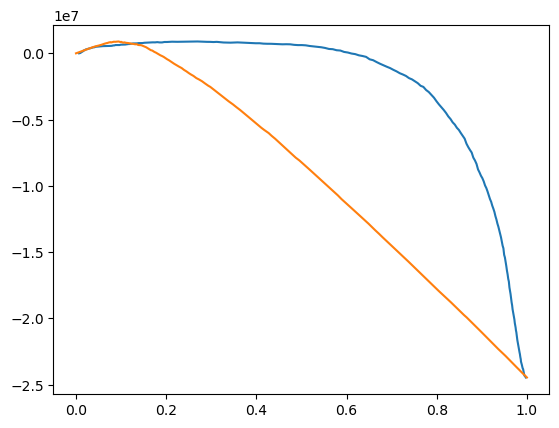

In [2896]:
# import numpy as np
# import matplotlib.pyplot as plt
plt.plot(argcumsort['PD'], argcumsort['ProfitCum'])
plt.plot(argcumsort['AR'], argcumsort['ProfitCum'])

In [2897]:
argcumsort2=argcumsort.copy()
argcumsort2=argcumsort2.sort_values(by='ProfitCum',ascending=False)
argcumsort2=argcumsort2.reset_index()
print(argcumsort2['ProfitCum'][0])
argcumsort2.head()
#896 902,65

895744.6581200542


,index,PD,Profit,NCum,AR,ProfitCum
0,102,0.269706,895744.658120,1206,0.094396,895744.658120
1,100,0.256341,894954.136684,1175,0.091969,894954.136684
2,101,0.262969,890122.166811,1189,0.093065,890122.166811
3,99,0.249824,889331.645375,1158,0.090639,889331.645375
4,103,0.276550,885412.688247,1222,0.095648,885412.688247


In [2898]:
# Scoring code

vars_sc=list(pd.unique(Scorecard[variable_name]))

vars_num=Scorecard[Scorecard[type_name]=='INT'].copy()
vars_sc_num=list(pd.unique(vars_num[variable_name]))

vars_nom=Scorecard[Scorecard[type_name]=='NOM'].copy()
vars_sc_nom=list(pd.unique(vars_nom[variable_name]))

with open('scoring_code.sas','w') as f:
    f.write('proc sql; \n')
    f.write('create table  &zbior._score as \n')
    f.write('select indataset.*  \n')
    for var in vars_sc_num:
        scv=Scorecard[Scorecard[variable_name]==var].copy()
        scv=scv.reset_index()
        f.write(', case \n')
        for i in range(scv.shape[0]):
            war=scv[condition_name][i]
            score=scv[score_name][i]
            if war.count('<')==2:
                f.write('when '+war.rsplit('<',1)[0]+' and '+war.rsplit('<=',1)[1]+' then '+str(score)+' \n')
            if war.count('<')==1 and war.count('<>')==0:
                f.write('when '+war+' then '+str(score)+' \n')
            if war.count('= '+symbol_missing)==1:
                f.write('when '+war.split(' ')[0]+' is null then '+str(score)+' \n')
            if war.count('<> '+symbol_missing)==1:
                f.write('when '+war.split(' ')[0]+' is not null then '+str(score)+' \n')
        score=scv[score_name][0]
        f.write('else '+str(score)+' end as PSC_'+var+' \n')
        f.write(' \n')
        
    for var in vars_sc_nom:
        scv=Scorecard[Scorecard[variable_name]==var].copy()
        scv=scv.reset_index()
        f.write(', case \n')
        index_other=0;
        for i in range(scv.shape[0]):
            war=scv[condition_name][i]
            score=scv[score_name][i]
            if war.count(',')==0 and war.count(symbol_other)==0:
                f.write('when '+var+' in ('+"'"+war+"'"+') then '+str(score)+' \n')
            if war.count(',')>0 and war.count(symbol_other)==0:
                f.write('when '+var+' in ('+"'"+war.split(', ')[0]+"'")
                for j in range(war.count(',')):
                    f.write(', '+"'"+war.split(', ')[j+1]+"'")
                f.write(') then '+str(score)+' \n')
            if war.count(symbol_other)==1:
                index_other=i
        score=scv[score_name][index_other]
        f.write('else '+str(score)+' end as PSC_'+var+' \n')
        f.write(' \n')
    
    f.write('/* , 1/(1+exp(-('+str(model_cal.params[0])+'*(0.0')
    for var in vars_sc:            
        f.write('+ calculated PSC_'+var)
    f.write(')+('+str(model_cal.params[1])+')))) as '+prob_event+' */ \n')
    f.write(' \n')
    
    f.write(', 0.0 \n')
    for var in vars_sc:            
        f.write('+ calculated PSC_'+var+' ')
    f.write(' as SCORECARD_POINTS \n')
    
    f.write(' \n')
    f.write('from &zbior as indataset; \n')
    f.write('quit; \n')

In [2899]:
#!pip3 install varclushi

In [2900]:
#!pip3 install factor_analyzer

In [2901]:
# Variable clustering
#from varclushi import VarClusHi

In [2902]:
# demo1_df.drop('quality',axis=1,inplace=True)
demo1_vc = VarClusHi(logit_train[vars_selected],maxeigval2=0.1,maxclus=None)
demo1_vc.varclus()

In [2903]:
writer = pd.ExcelWriter('Variable_Clustering.xlsx', engine='xlsxwriter')

demo1_vc.info.to_excel(writer, sheet_name='Info', index_label=None, index=False)
demo1_vc.rsquare.to_excel(writer, sheet_name='Clusters', index_label=None, index=False)

writer.save()
writer.close()

/opt/anaconda3/lib/python3.9/site-packages/xlsxwriter/workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


In [2904]:
#!pip3 install shap

In [2905]:
#import shap

In [2906]:
#!conda install -c conda-forge shap

In [2907]:
#!pip3 install numpy==1.23.1

In [2908]:
# XAI Explainable artificial intelligence

features=list(result['Efects'][variable_name].copy())
features.remove('Intercept')

# X=logit_train[features]
# y=logit_train[target_name]

X=scored_train[features]
y=scored_train[target_name]

#import shap
logmodel = LogisticRegression()
logmodel.fit(X,y)

for i,v in enumerate(features):
#     logmodel.coef_[0][i]=result['Efects']['Estimation'][i]
    logmodel.coef_[0][i]=1.0
    

logmodel.intercept_=0.0

#explainer=shap.LinearExplainer(logmodel,X)
#shap_values=explainer(X)



/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [2909]:
 print(logmodel.coef_,logmodel.intercept_)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]] 0.0


In [2910]:
#shap.summary_plot(shap_values,X,plot_type='bar')

In [2911]:
#shap.plots.bar(shap_values)

In [2912]:
#shap.summary_plot(shap_values,X,plot_type='violin')

In [2913]:
#shap.plots.beeswarm(shap_values)

In [2914]:
#shap.waterfall_plot(shap_values[0])

In [2915]:
#shap.initjs()
#shap.plots.force(shap_values[0])

In [2916]:
suma=0
for v in features:
    print(v, X[v][0])
    suma=suma+X[v][0]
print('Score',suma)

act_ccss_n_statC 143.0
act_ccss_maxdue 165.0
app_number_of_children 177.0
act_cc 168.0
app_income 170.0
act_ccss_seniority 143.0
act_ccss_n_statB 170.0
app_char_marital_status_gender 152.0
app_char_marital_status_job_code 155.0
act_cins_n_loans_hist 146.0
Score 1589.0


In [2917]:
#shap_values[0]

In [2918]:
for v in features:
    a=X[v][0]-X[v].mean()
    print(v, a)

act_ccss_n_statC -16.92832382869284
act_ccss_maxdue 6.97539975399755
app_number_of_children 21.67304036676731
act_cc -1.0956055015095671
app_income 2.8243318796824326
act_ccss_seniority -12.583920384658398
act_ccss_n_statB 12.696298781169617
app_char_marital_status_gender 2.6303253941630373
app_char_marital_status_job_code 3.103656491110371
act_cins_n_loans_hist -2.1984792575198355


In [2919]:
XS=X.copy()
XS['sum']=0.0
for v in features:
   XS['sum']=XS['sum']+X[v]

XS['sum'].mean()

1571.9032763054904

In [2920]:
#XShap=pd.DataFrame(shap_values.values)
#XShap['sum']=0.0
#for i,v in enumerate(features):
#    XShap['sum']=XShap['sum']+XShap[i]
    
#XShap['sum'].mean()

In [2921]:
#a=shap_values.base_values.mean()+XShap['sum'].mean()
#a

In [2922]:
# dict = {'gini': [0.73, 0.7299900350659401, 0.7266378402931, 0.7350075157451894, 0.7370777728407707],
#         'profit':[896902.65, 914148.5631010146, 895811.5758456348, 920026.9987934805, 927931.8307756819],
#         'description':["number_vars=15- number_features=6", "number_vars=12 number_features=6", "number_vars=10 number_features=5" "number_vars=15 number_features=7", "number_vars=20 number_features=70.6256871649501146","ncategories_nom=5 - & (Gini_vars[delta_gini]<0.02 - number_vars=12 number_features=6"]}
# df = pd.DataFrame(dict)
 
# # append data frame to CSV file
# df.to_csv('results.csv', index=False)
#description_results = "alp=-alpp.sum()+300 to alp=+alpp.sum()+300"

In [2923]:
#df.head()
#description_results = "lgd=0.5"
#="ncategories_nom=4"
description_results = "min_prebin_size=0.05 for OptimalBinning"

In [2924]:
data = {
    'gini': [gini],
    'profit': [argcumsort2['ProfitCum'][0]],
    'description': [description_results]
}
# Make data frame of above data
df = pd.DataFrame(data)
 
# append data frame to CSV file
#df.to_csv('result.xlsx', mode='a',  header=False)
# append data frame to CSV file
df.head()
df.to_csv('results.csv', mode='a', index=False, header=False)

In [2925]:
#df_results.to_csv('results.csv', index=False)

In [2926]:
df_results = pd.read_csv("results.csv")
df_results.head(10)

,gini,profit,description
0,0.726638,895811.575846,number_vars=10 number_features=5number_vars=15...
1,0.735008,920026.998793,number_vars=20 number_features=70.625687164950...
2,0.737078,927931.830776,ncategories_nom=5 - & (Gini_vars[delta_gini]<0...
3,0.625687,799338.516760,ncategories_nom=5 - & (Gini_vars[delta_gini]<0...
4,0.733273,896902.653482,ncategories_nom=4 - & (Gini_vars[delta_gini]<0...
5,0.733273,896902.653482,ncategories_nom=5 - & (Gini_vars[delta_gini]<0...
6,0.733273,896902.653482,ncategories_nom=5number_vars=12 number_features=6
7,0.726638,895811.575846,ncategories_nom=5 Gini_vars[delta_gini]<0.2 nu...
8,0.726638,895811.575846,ncategories_nom=5 Gini_vars[delta_gini]<0.2 nu...
9,0.726638,895811.575846,ncategories_nom=5 Gini_vars[delta_gini]<0.2 nu...


In [2927]:
# df_results = pd.read_excel("result.xlsx")
# df_results.head(10)

In [2928]:
# decorator
def pandas_display(func):
    default_1 = pd.options.display.max_rows
    default_2 = pd.options.display.max_colwidth
    def wrapper(_df, exclude_cols=None, properties=None, limit_float=2):
        pd.options.display.max_rows = 1000
        pd.options.display.max_colwidth = None
        func(_df, exclude_cols, properties, limit_float)
        pd.options.display.max_rows = default_1
        pd.options.display.max_colwidth = default_2
    return wrapper
    
    
@pandas_display
def display_df(self, exclude_cols, properties, limit_float):
    if exclude_cols is not None:
        if not isinstance(exclude_cols, list):
            exclude_cols = list(exclude_cols)
        cols = [x for x in self.columns.values if x not in set(exclude_cols)]
        self = self[cols]

    if not properties:
        properties = {
            'text-align': 'left',
            'white-space': 'pre-wrap',
            'word-wrap': 'break-word',
            'width': '530px',
            'max-width': '530px',
        }
        
    a = self.style.set_properties(**properties)
#     if limit_float is not None:
#         a.format(thousands=',', precision=limit_float)
    display(a)
    
d = display_df
pd.DataFrame.d = d

In [2929]:
df_results.d()

,gini,profit,description
0,0.726638,895811.575846,number_vars=10 number_features=5number_vars=15 number_features=7
1,0.735008,920026.998793,number_vars=20 number_features=70.6256871649501146
2,0.737078,927931.830776,ncategories_nom=5 - & (Gini_vars[delta_gini]<0.02 - number_vars=12 number_features=6
3,0.625687,799338.516760,ncategories_nom=5 - & (Gini_vars[delta_gini]<0.02 - number_vars=12 number_features=6
4,0.733273,896902.653482,ncategories_nom=4 - & (Gini_vars[delta_gini]<0.1 - number_vars=12 number_features=6
5,0.733273,896902.653482,ncategories_nom=5 - & (Gini_vars[delta_gini]<0.1 - number_vars=12 number_features=6
6,0.733273,896902.653482,ncategories_nom=5number_vars=12 number_features=6
7,0.726638,895811.575846,ncategories_nom=5 Gini_vars[delta_gini]<0.2 number_vars=10 number_features=5
8,0.726638,895811.575846,ncategories_nom=5 Gini_vars[delta_gini]<0.2 number_vars=10 number_features=5 Model_list['max_pvalue']<=0.05
9,0.726638,895811.575846,ncategories_nom=5 Gini_vars[delta_gini]<0.2 number_vars=10 number_features=5 Model_list['max_pvalue']<=0.05
